# 부스팅 방법

## 에이다 부스트

에이다 부스트와 같은 부스트(boost) 방법은 미리 정해진 모형 집합을 사용하는 것이 아니라 단계적으로 모형 집합에 포함할 개별 모형을 선택한다. 부스트 방법에서는 성능이 떨어지는 개별 모형을 약 분류기(weak classifier)라고 한다. 개별 모형은 다음처럼 1과 -1을 예측하는 이진 분류(binary classification) 모형이다.

$$ k_m(x) = \begin{cases} 1 \\ -1 \end{cases} $$

최종 분류를 위한 개별 모형의 집합은 위원회(commitee) $C$라고 한다. 위원회 $C$는 다수결 방법을 사용하지 않고 각각의 개별 모형의 출력을 다음처럼 가중 선형 결합한 값을 판별 함수로 사용한다. 

$$ C_{(m-1)}(x_i) =  \text{sign} \left( \alpha_1k_1(x_i) + \cdots + \alpha_{m-1}k_{m-1}(x_i) \right) $$

부스팅 방법에서는 하나의 개별 모형에서 시작하여 개별 모형을 하나씩 추가하여 위원회의 멤버 수를 증가시킨다. 이러한 방법을 Stagewise Additive Modeling이라고 한다. 

위원회의 멤버가 될 개별 모형을 선별하는 방법으로는 지수 손실 함수(Exponential loss function) $L_i$를 사용한다.  

$$ E = \sum_{y_i \neq k_m(x_i)} L_i^{(m)} = \sum_{y_i \neq k_m(x_i)} e^{-y_i C_{m-1}(x_i)}$$ 

위 식에서 $-y_i C_{m-1}(x_i)$는 기존의 위원회의 예측값이 올바른 경우에는 $-1$, 틀린 경우에는 $+1$이 되는 값이다.

$$ y_i = C_{m-1} \;\; \rightarrow \;\; -y_i C_{m-1} = -1 $$
$$ y_i \neq C_{m-1} \;\; \rightarrow \;\; -y_i C_{m-1} = 1 $$


$m$번째 멤버의 모든 후보에 대해 위 손실 함수를 적용하여 가장 값이 작은 후보를 $m$번째 멤버로 선정한다.

멤버가 될 개별 모형이 선택된 후에는 그 개별 모형에 대한 최적의 가중치 $\alpha_m$를 결정해야 한다. 이 값은 다음처럼 계산한다.

$$ \epsilon_m = \dfrac{\sum_{y_i \neq k_m(x_i)} L_i^{(m)} }{ \sum_{i=1}^N L_i^{(m)}} $$

$$ \alpha_m = \frac{1}{2}\log\left( \frac{1 - \epsilon_m}{\epsilon_m}\right) $$ 

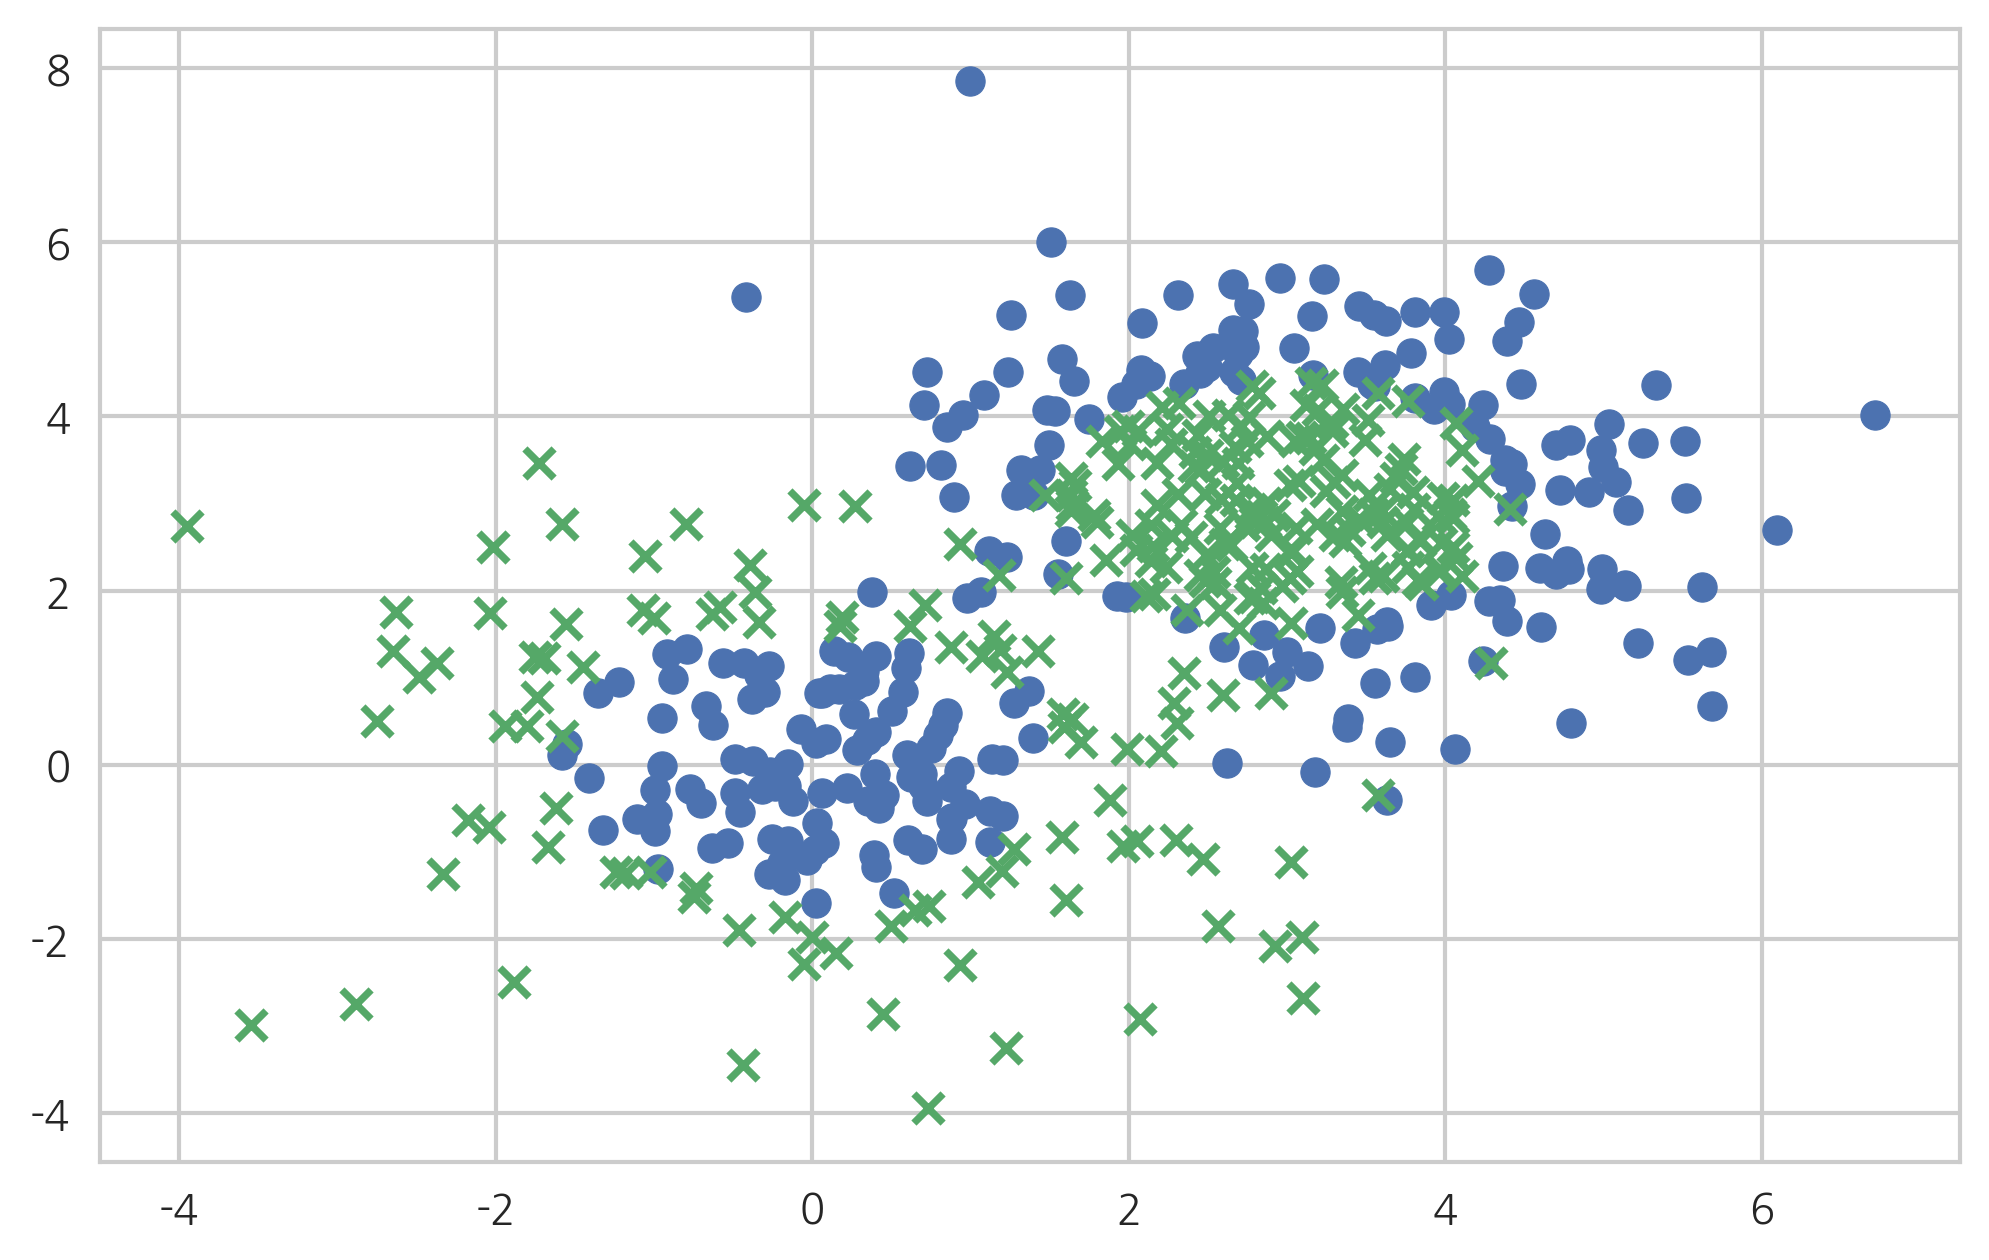

In [1]:
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='o')
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='x')
plt.show()

In [2]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

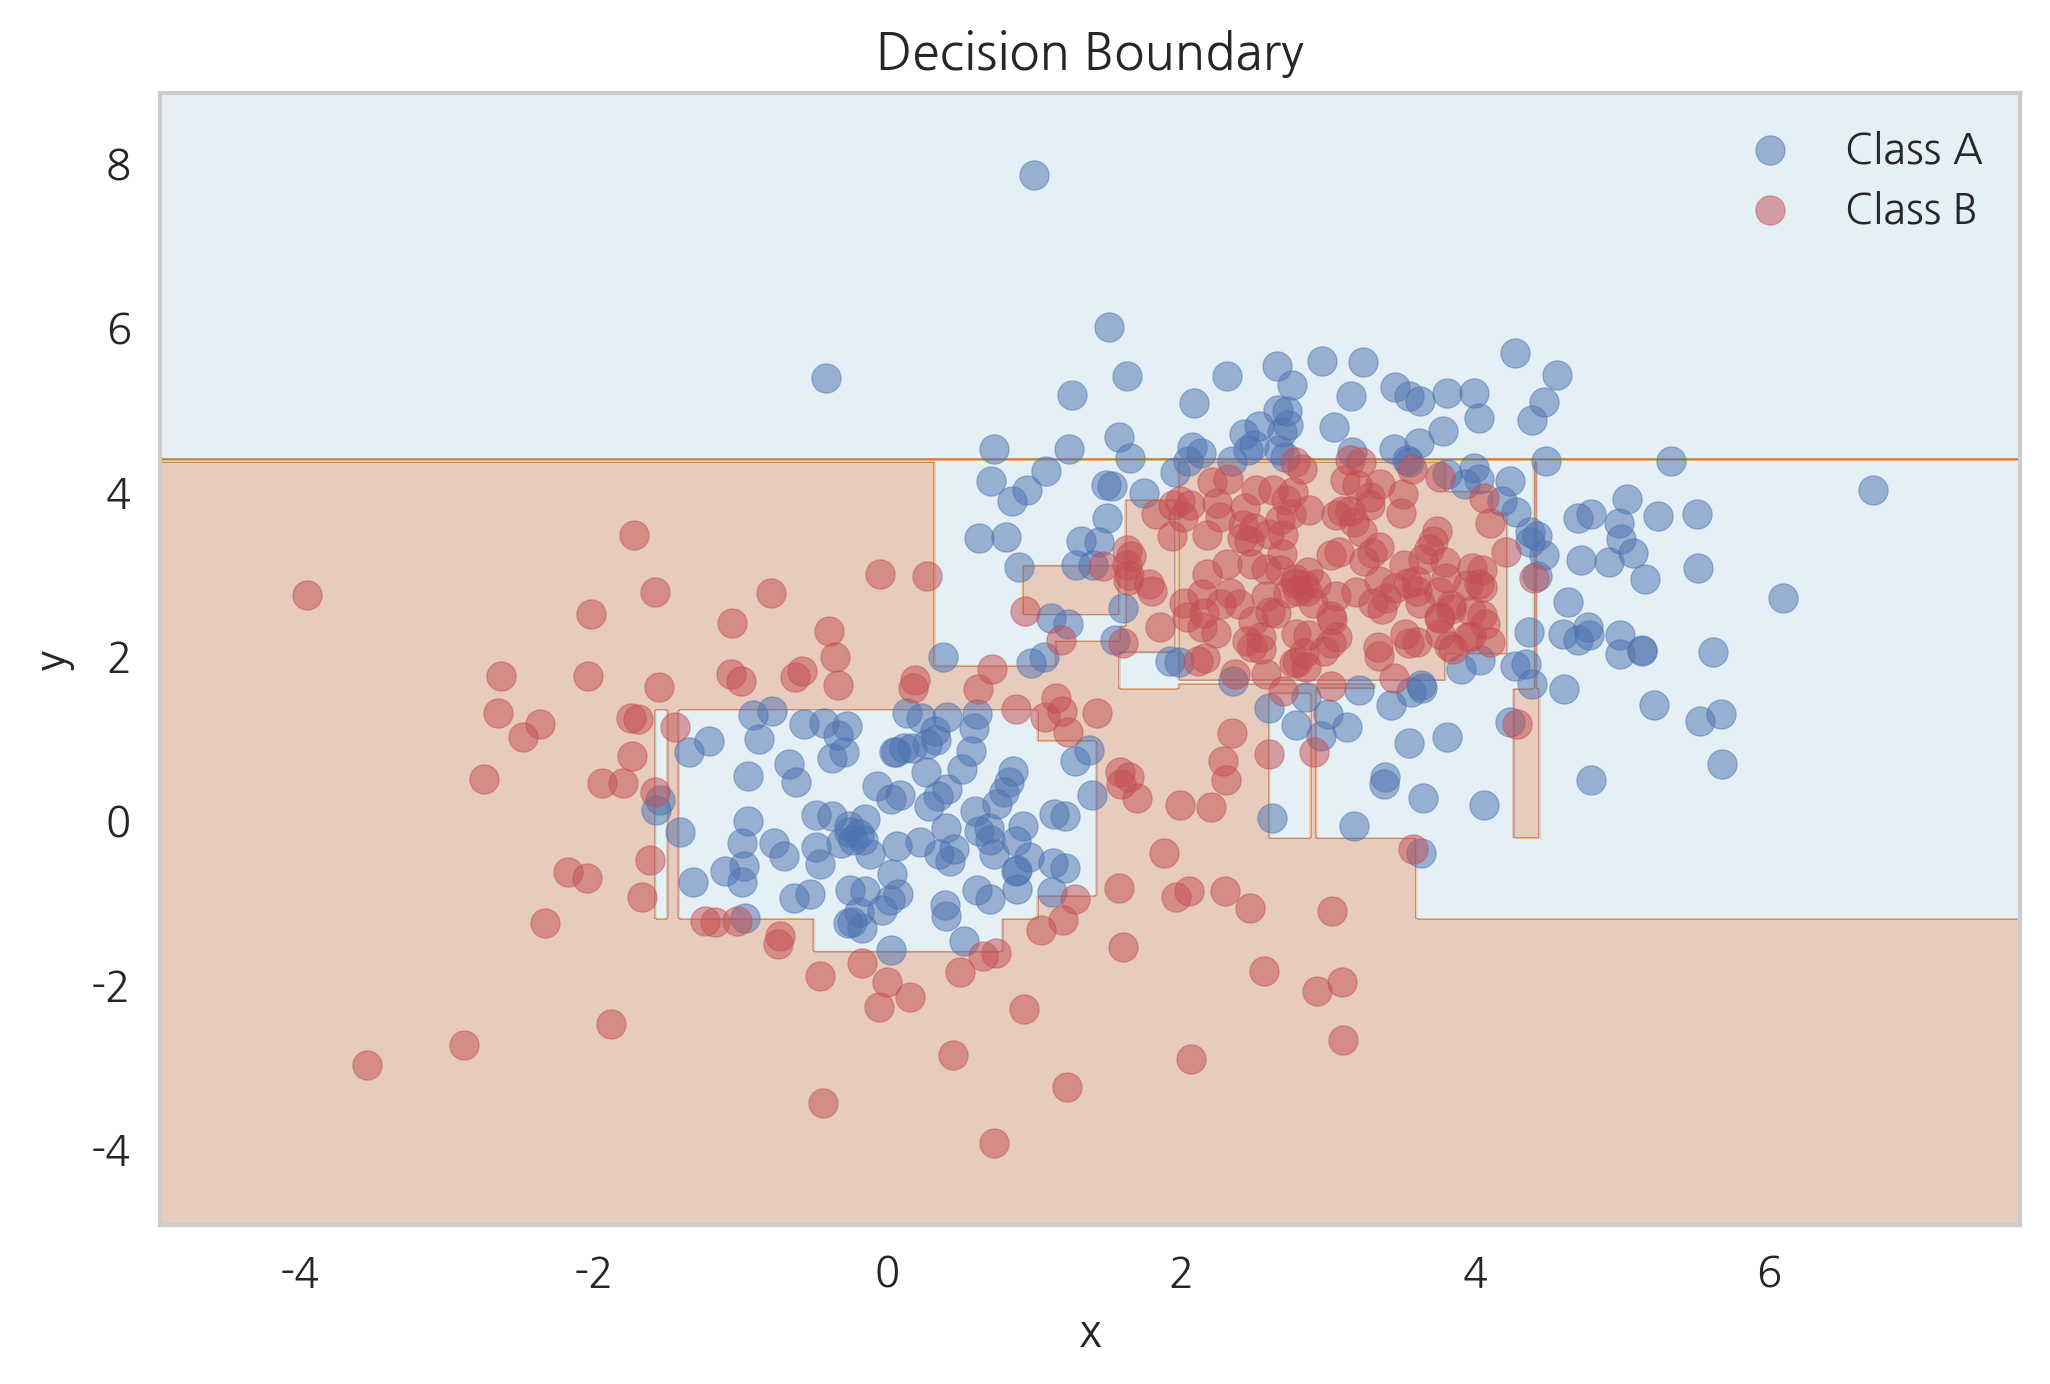

In [3]:
def plot_result(model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

    for i, n, c in zip(range(2), "AB", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, alpha=0.5, label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')
    plt.grid(False)
    plt.show()
    
plot_result(tree)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), 
                               algorithm="SAMME", n_estimators=100)
model_ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

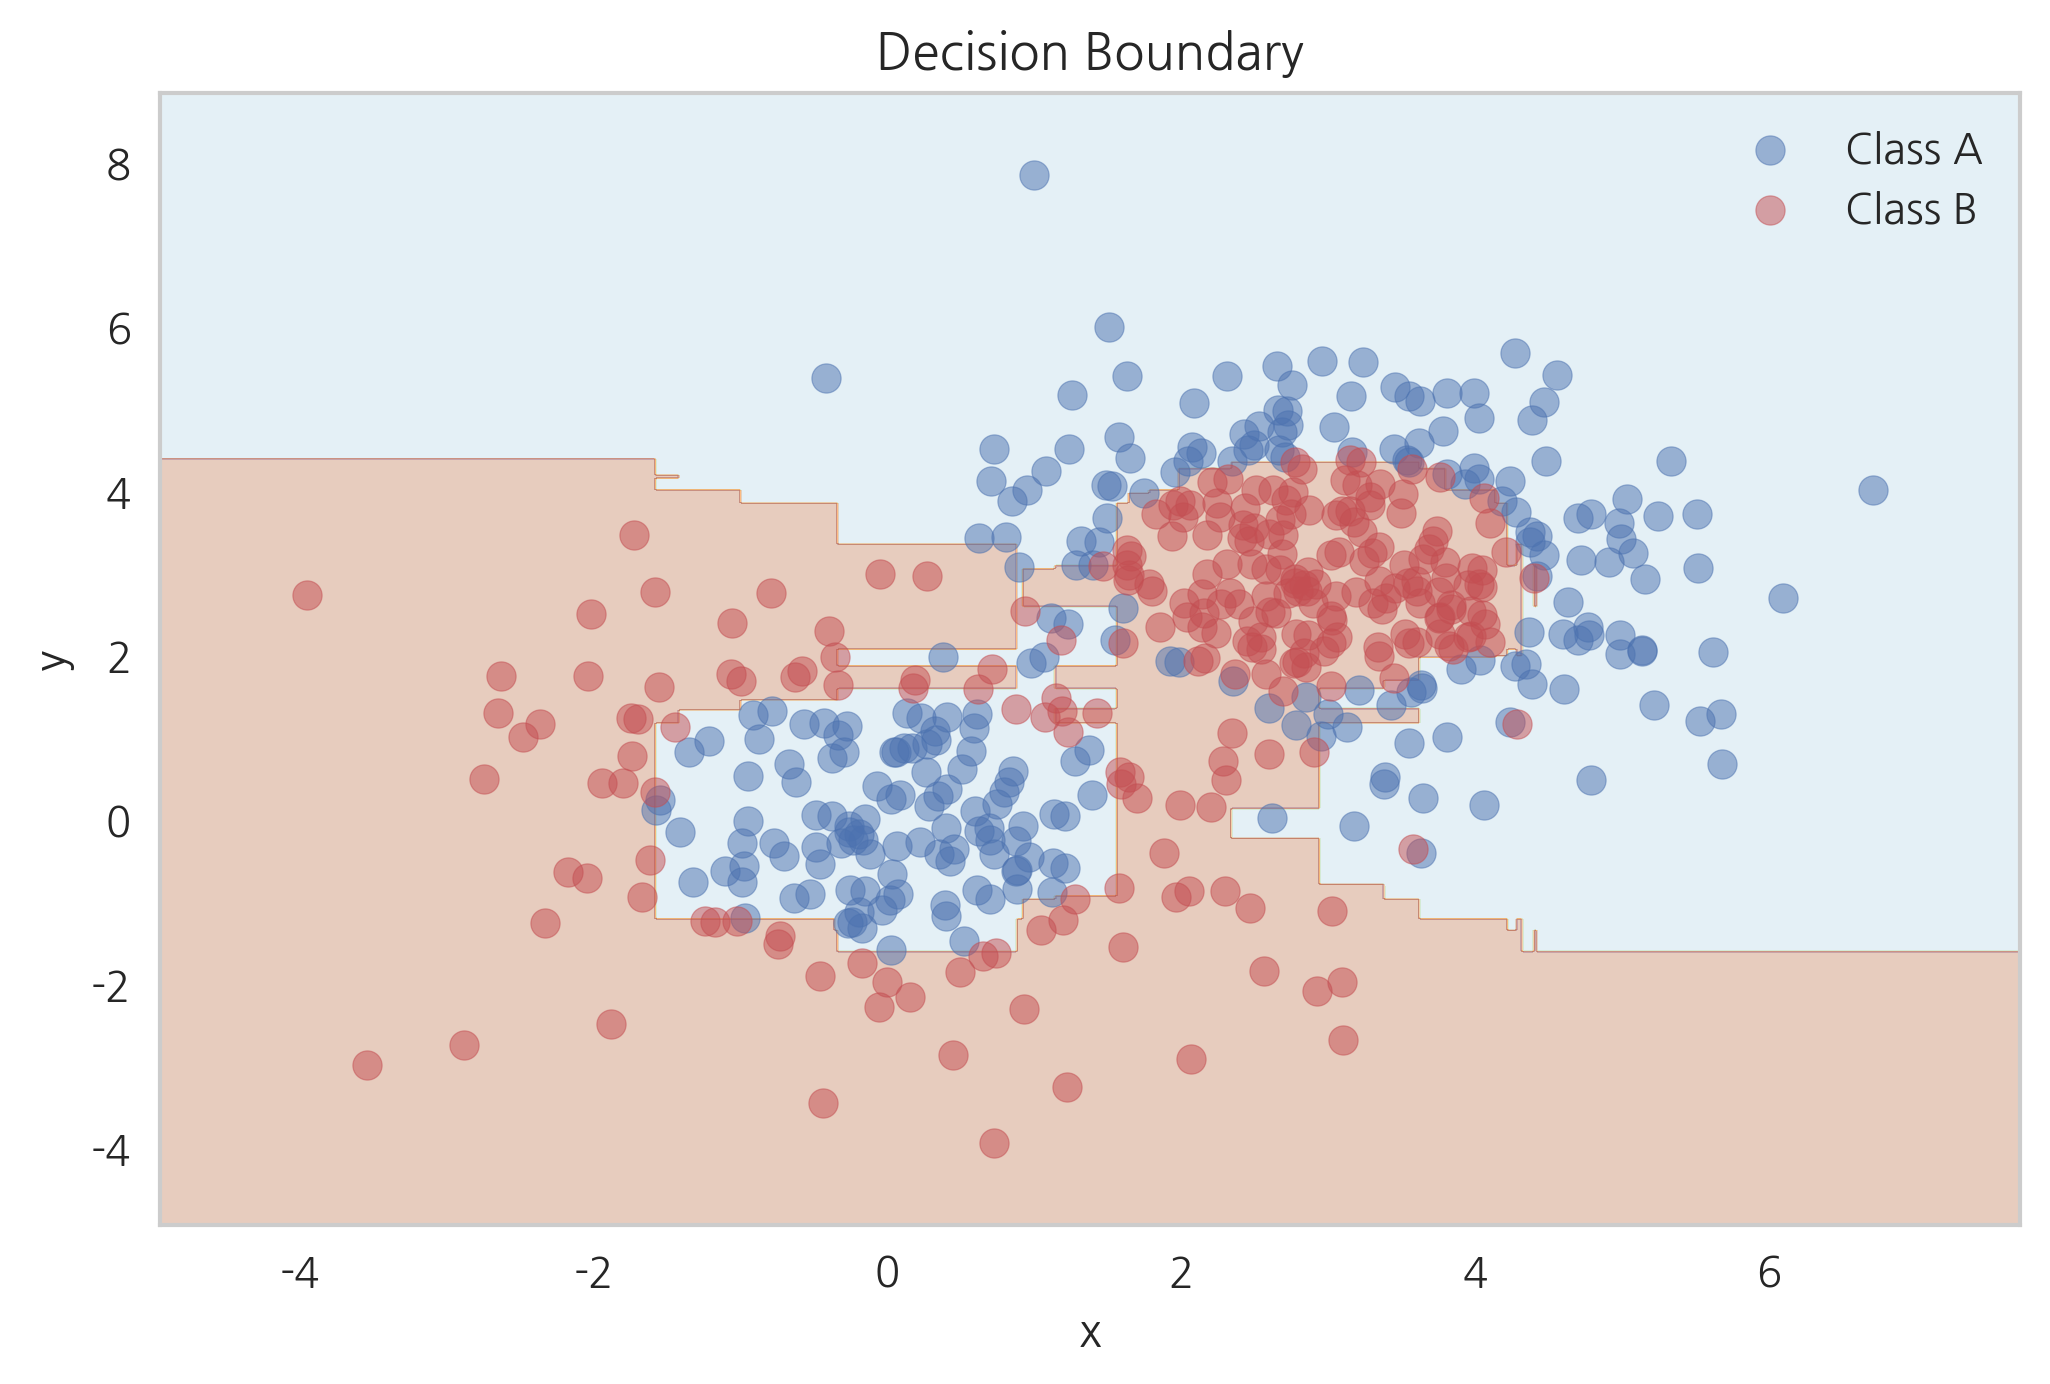

In [5]:
plot_result(model_ada)

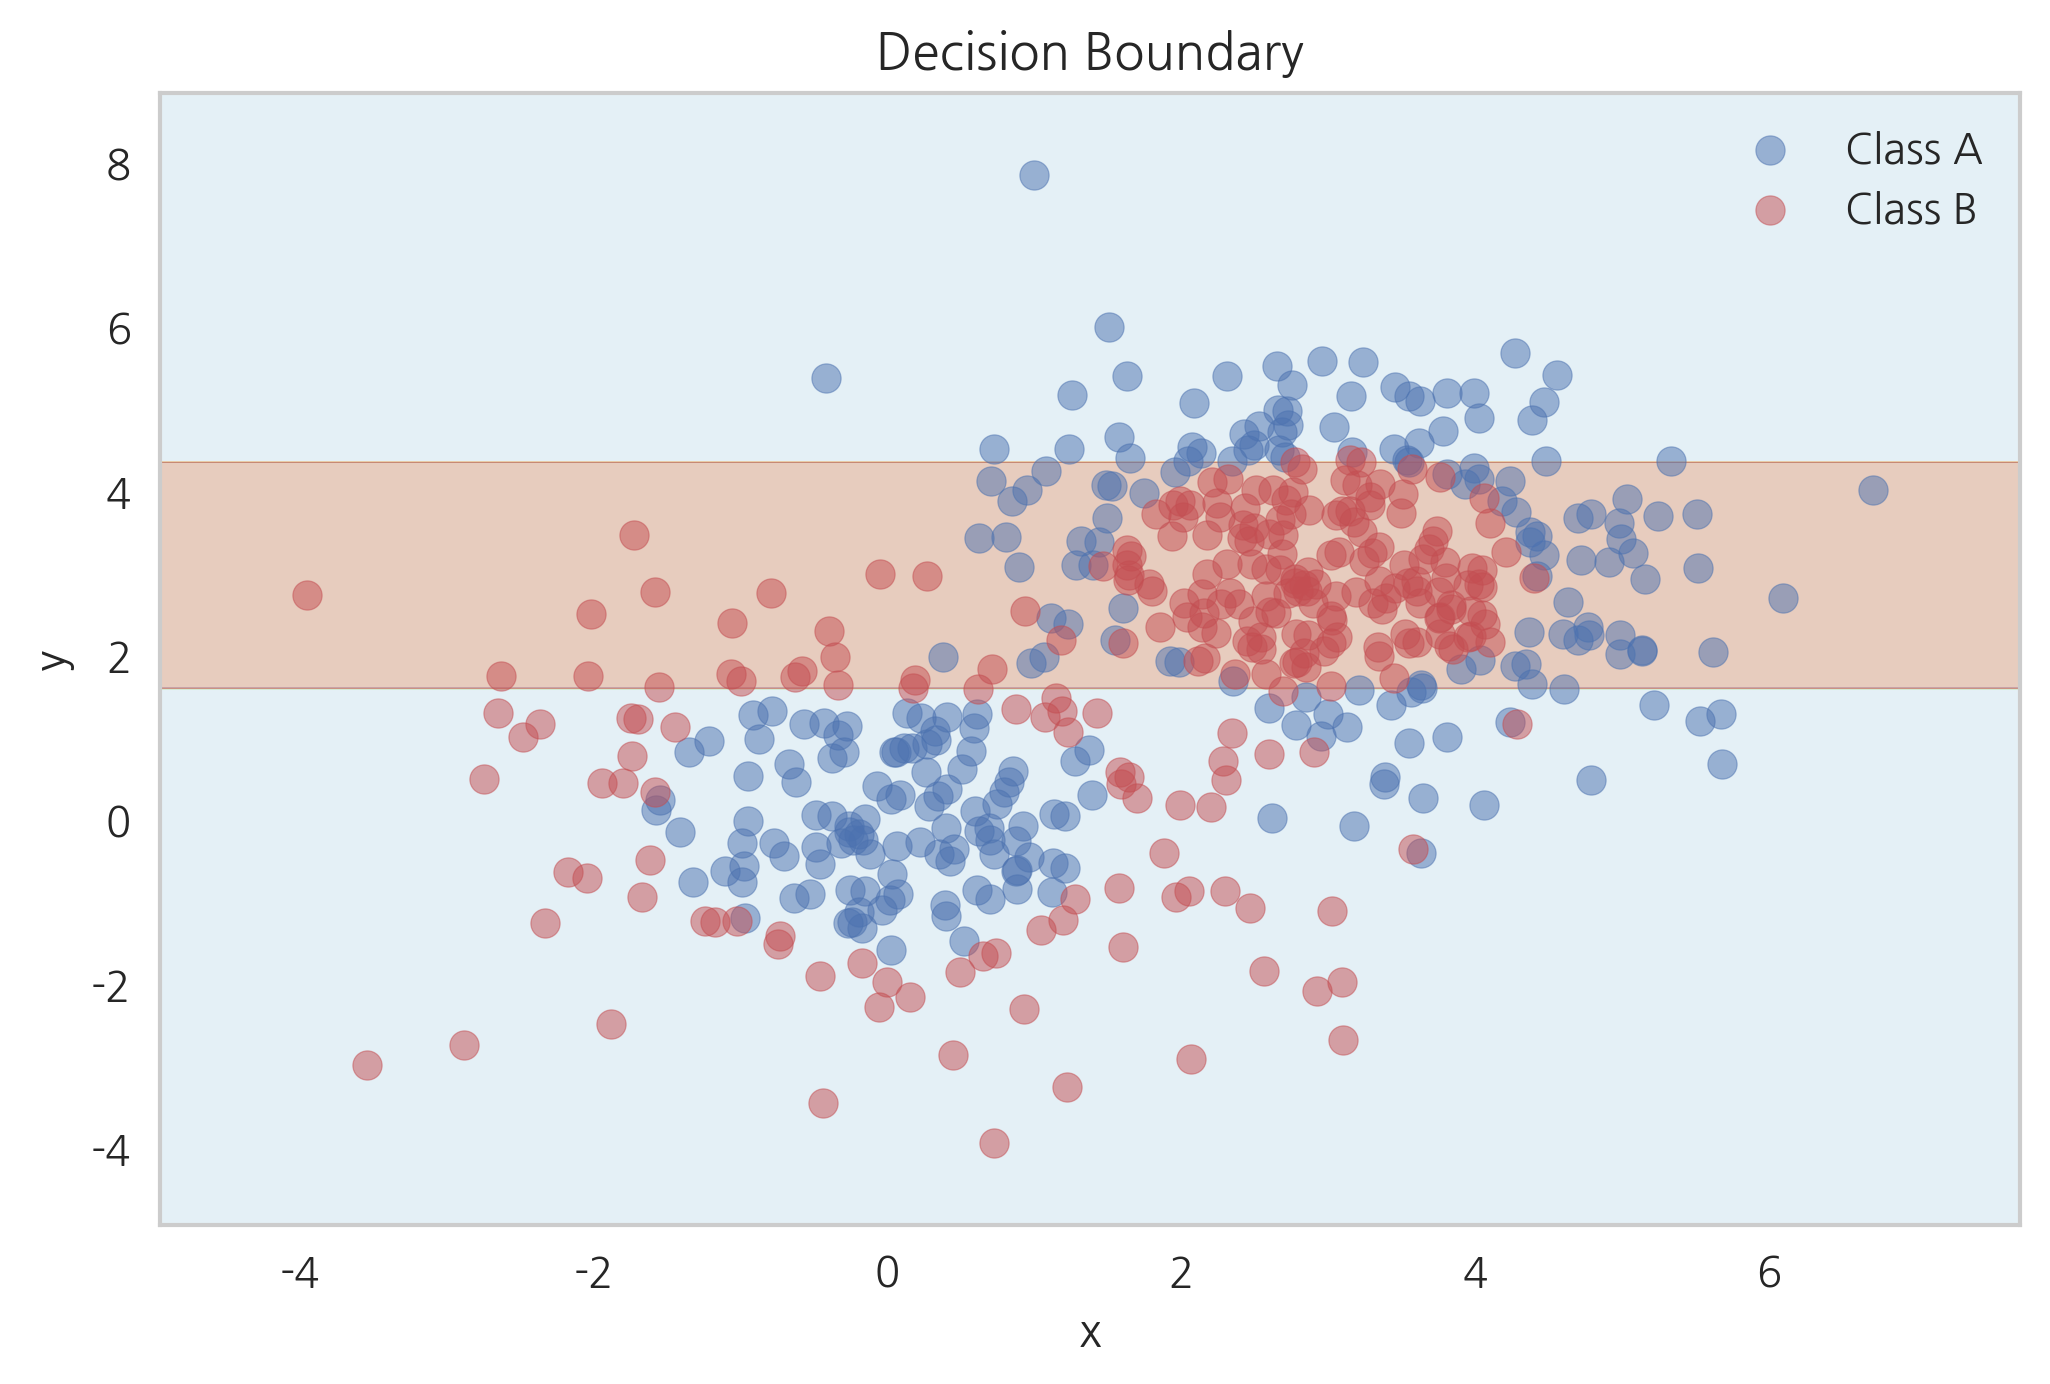

In [6]:
plot_result(model_ada.estimators_[0])

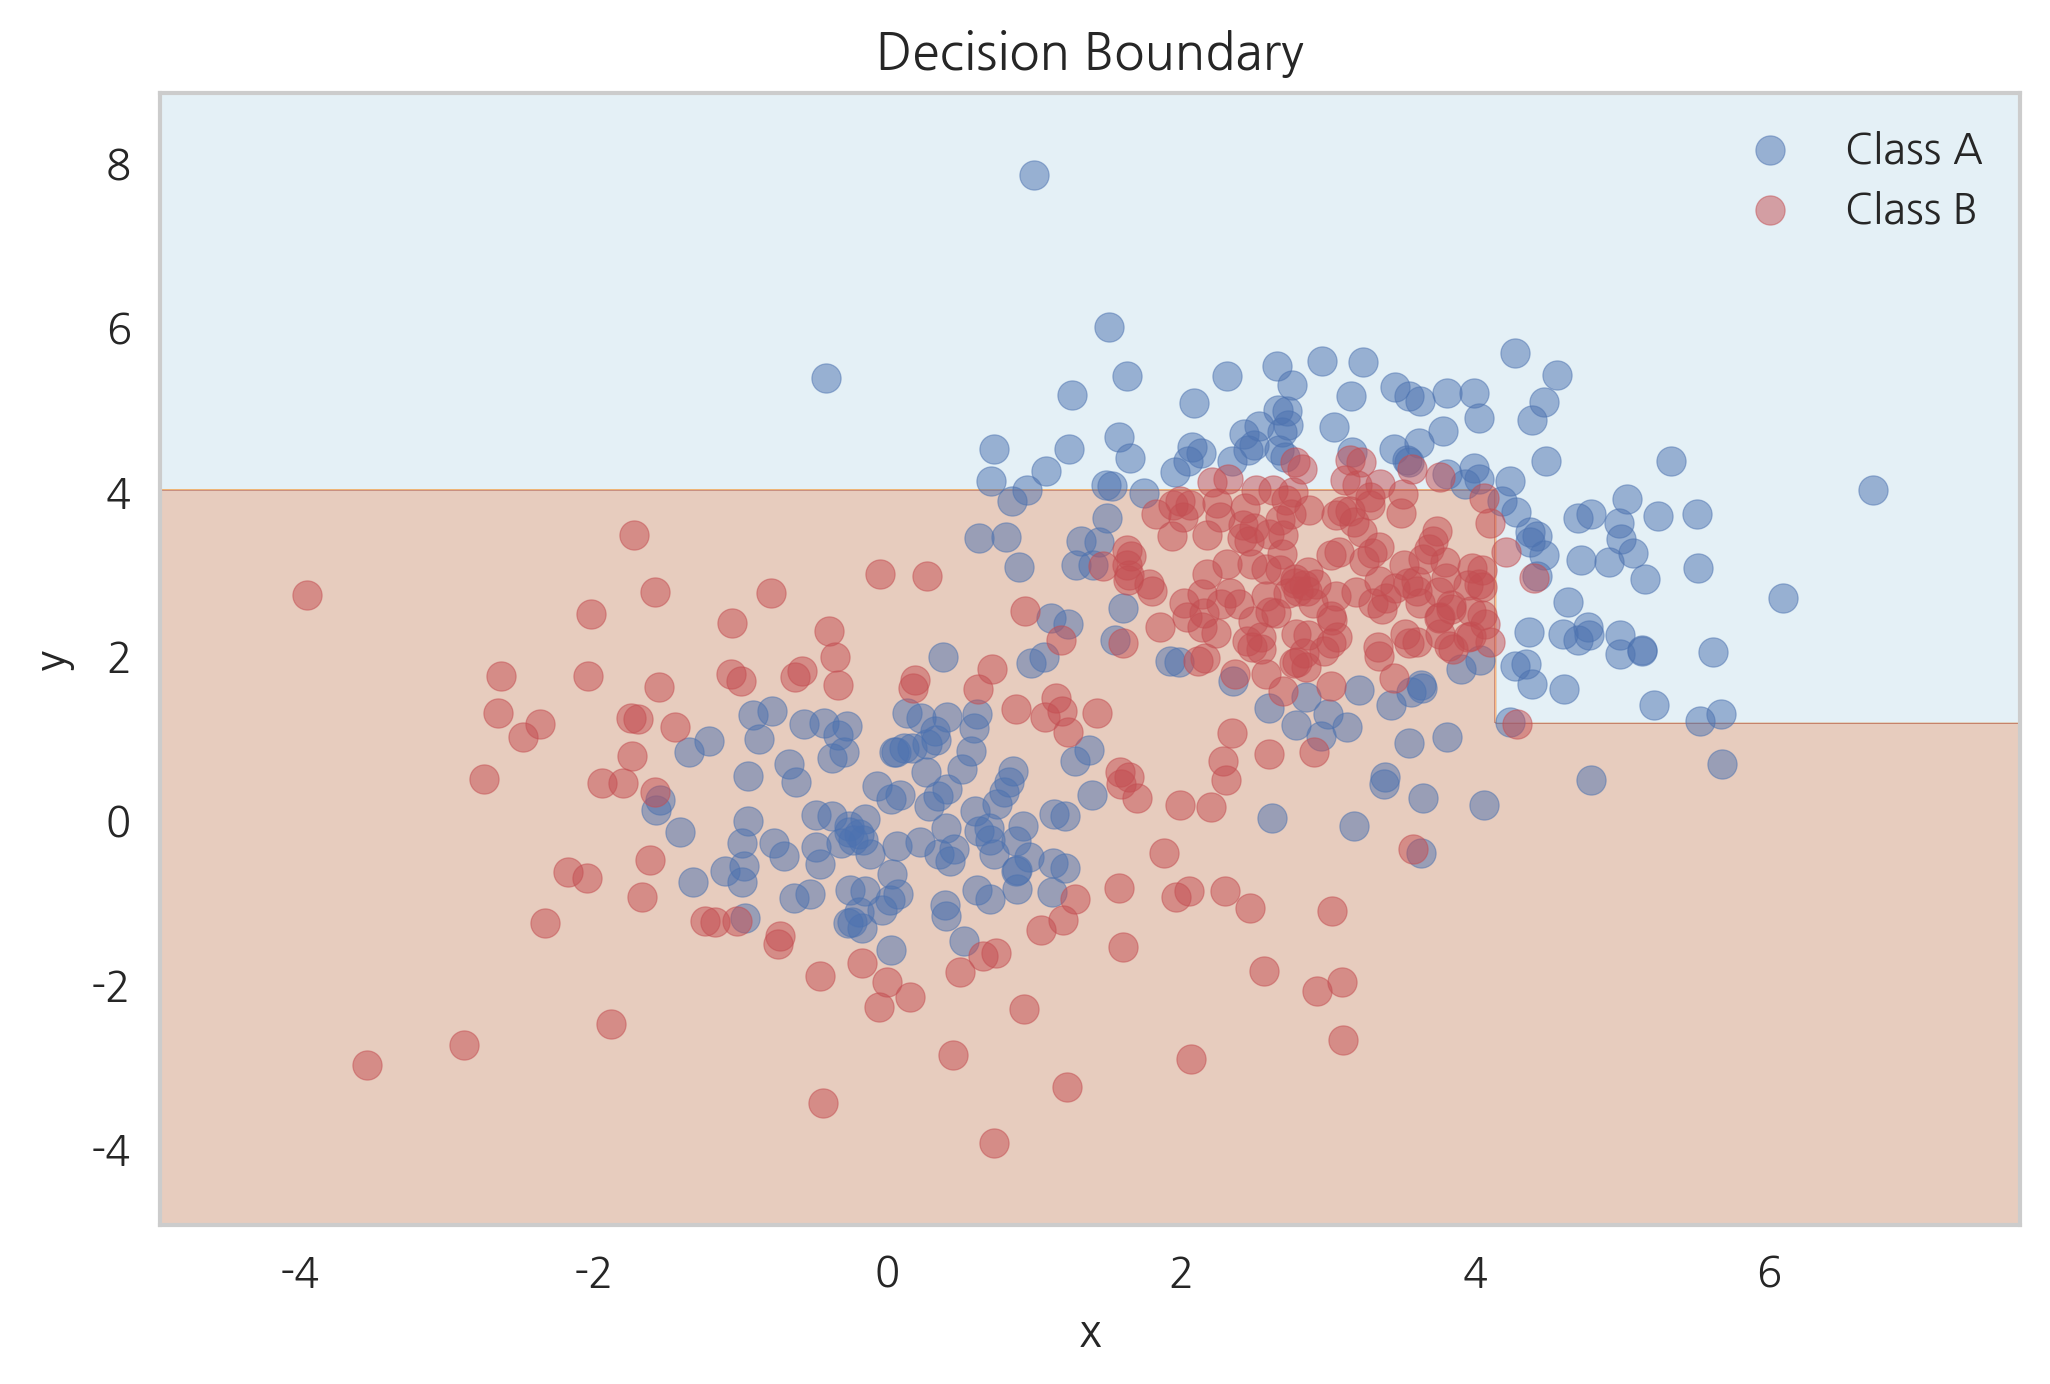

In [7]:
plot_result(model_ada.estimators_[1])

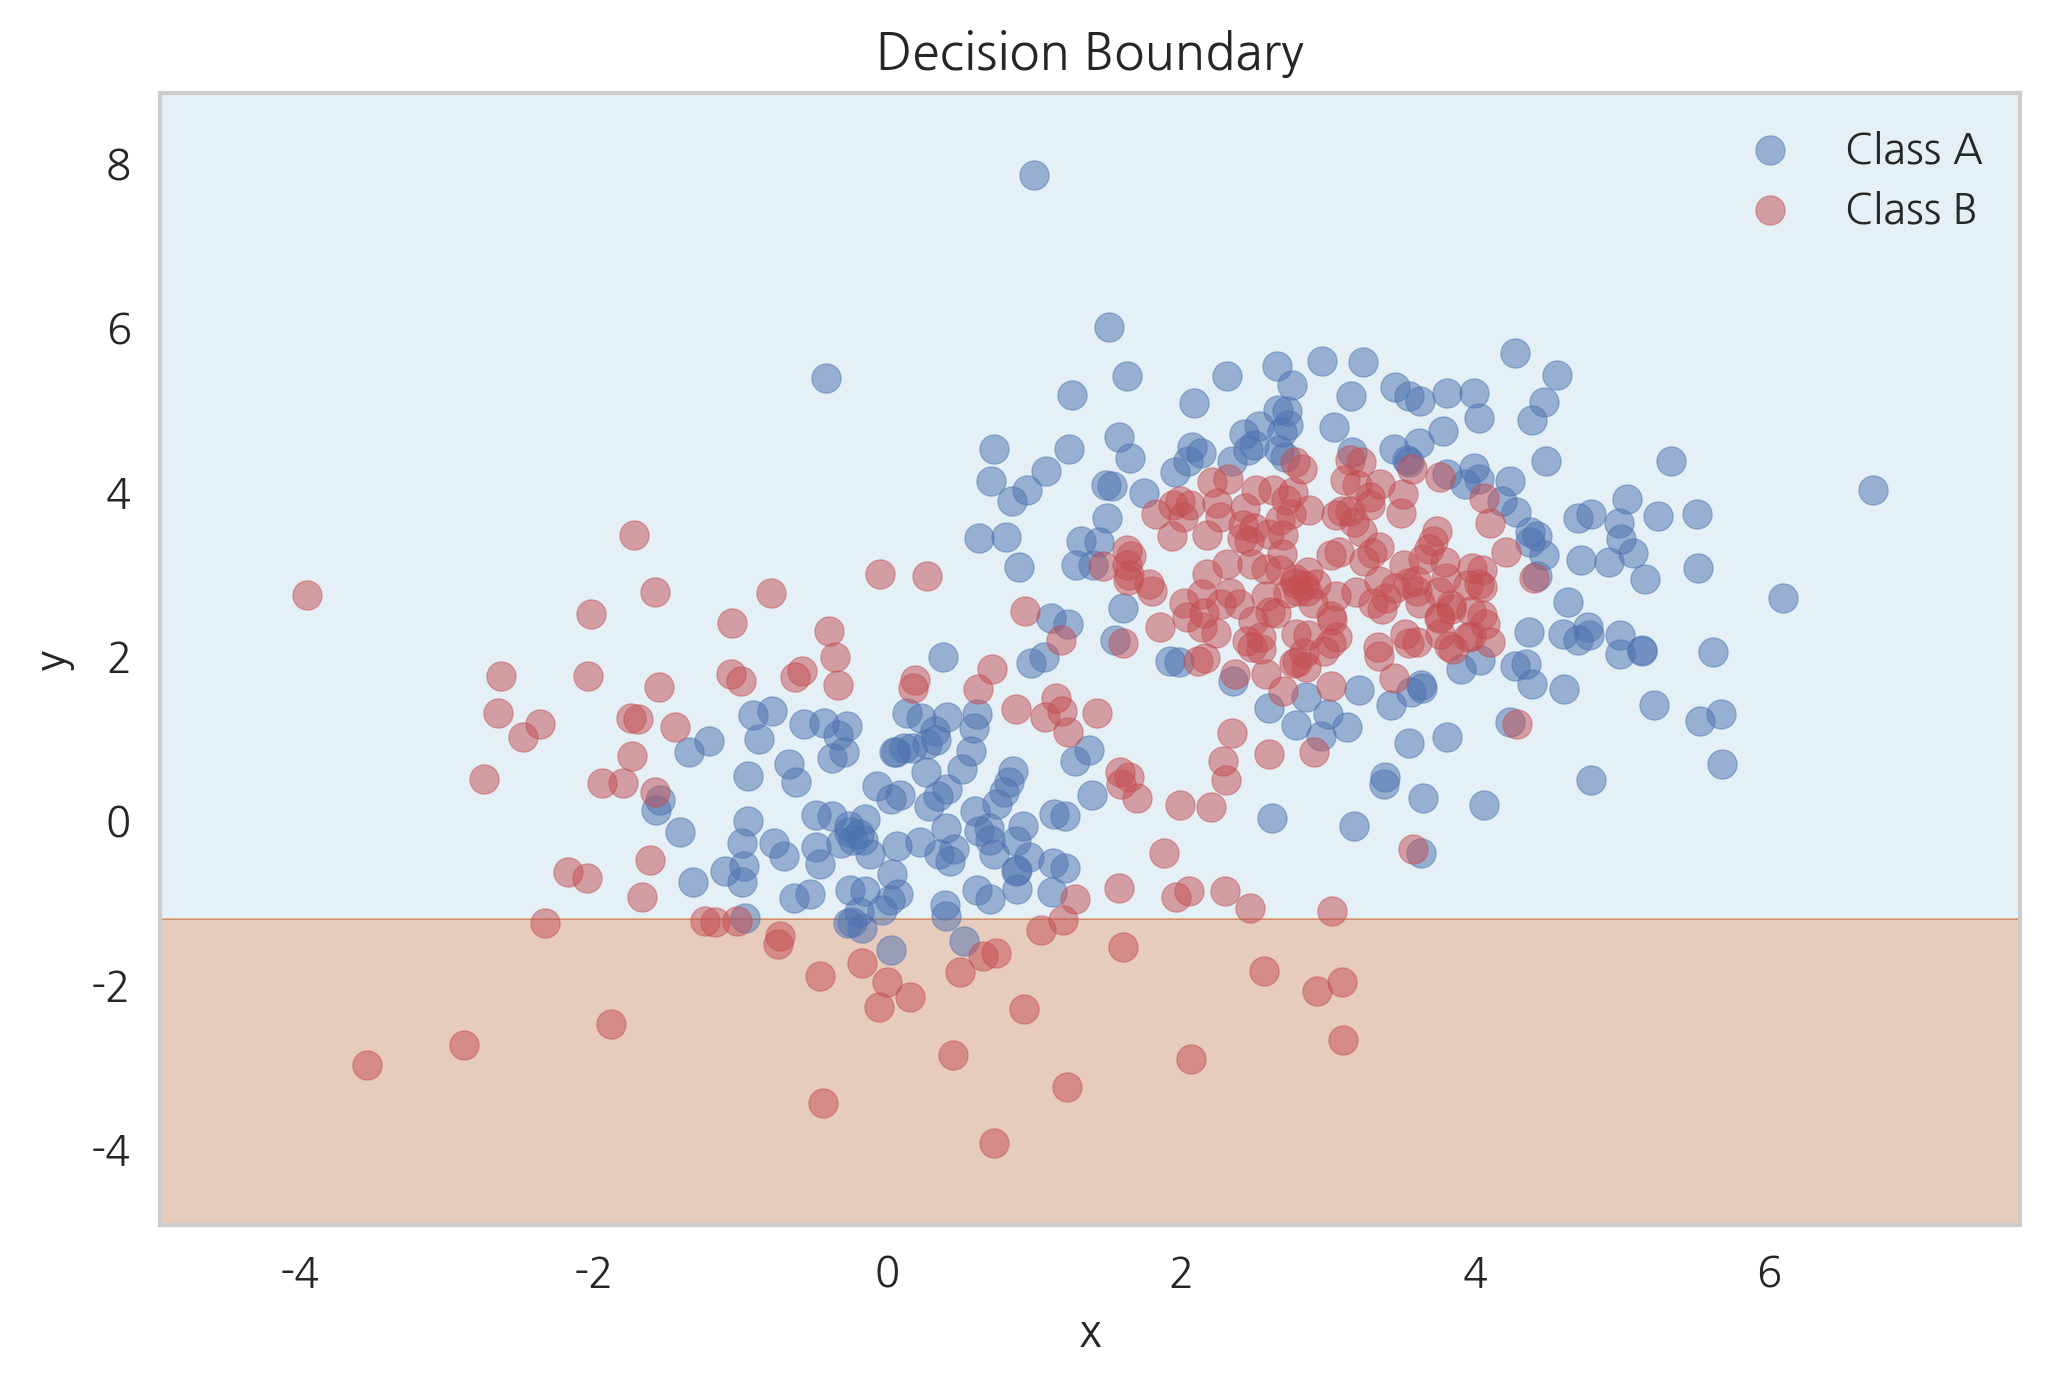

In [8]:
plot_result(model_ada.estimators_[2])

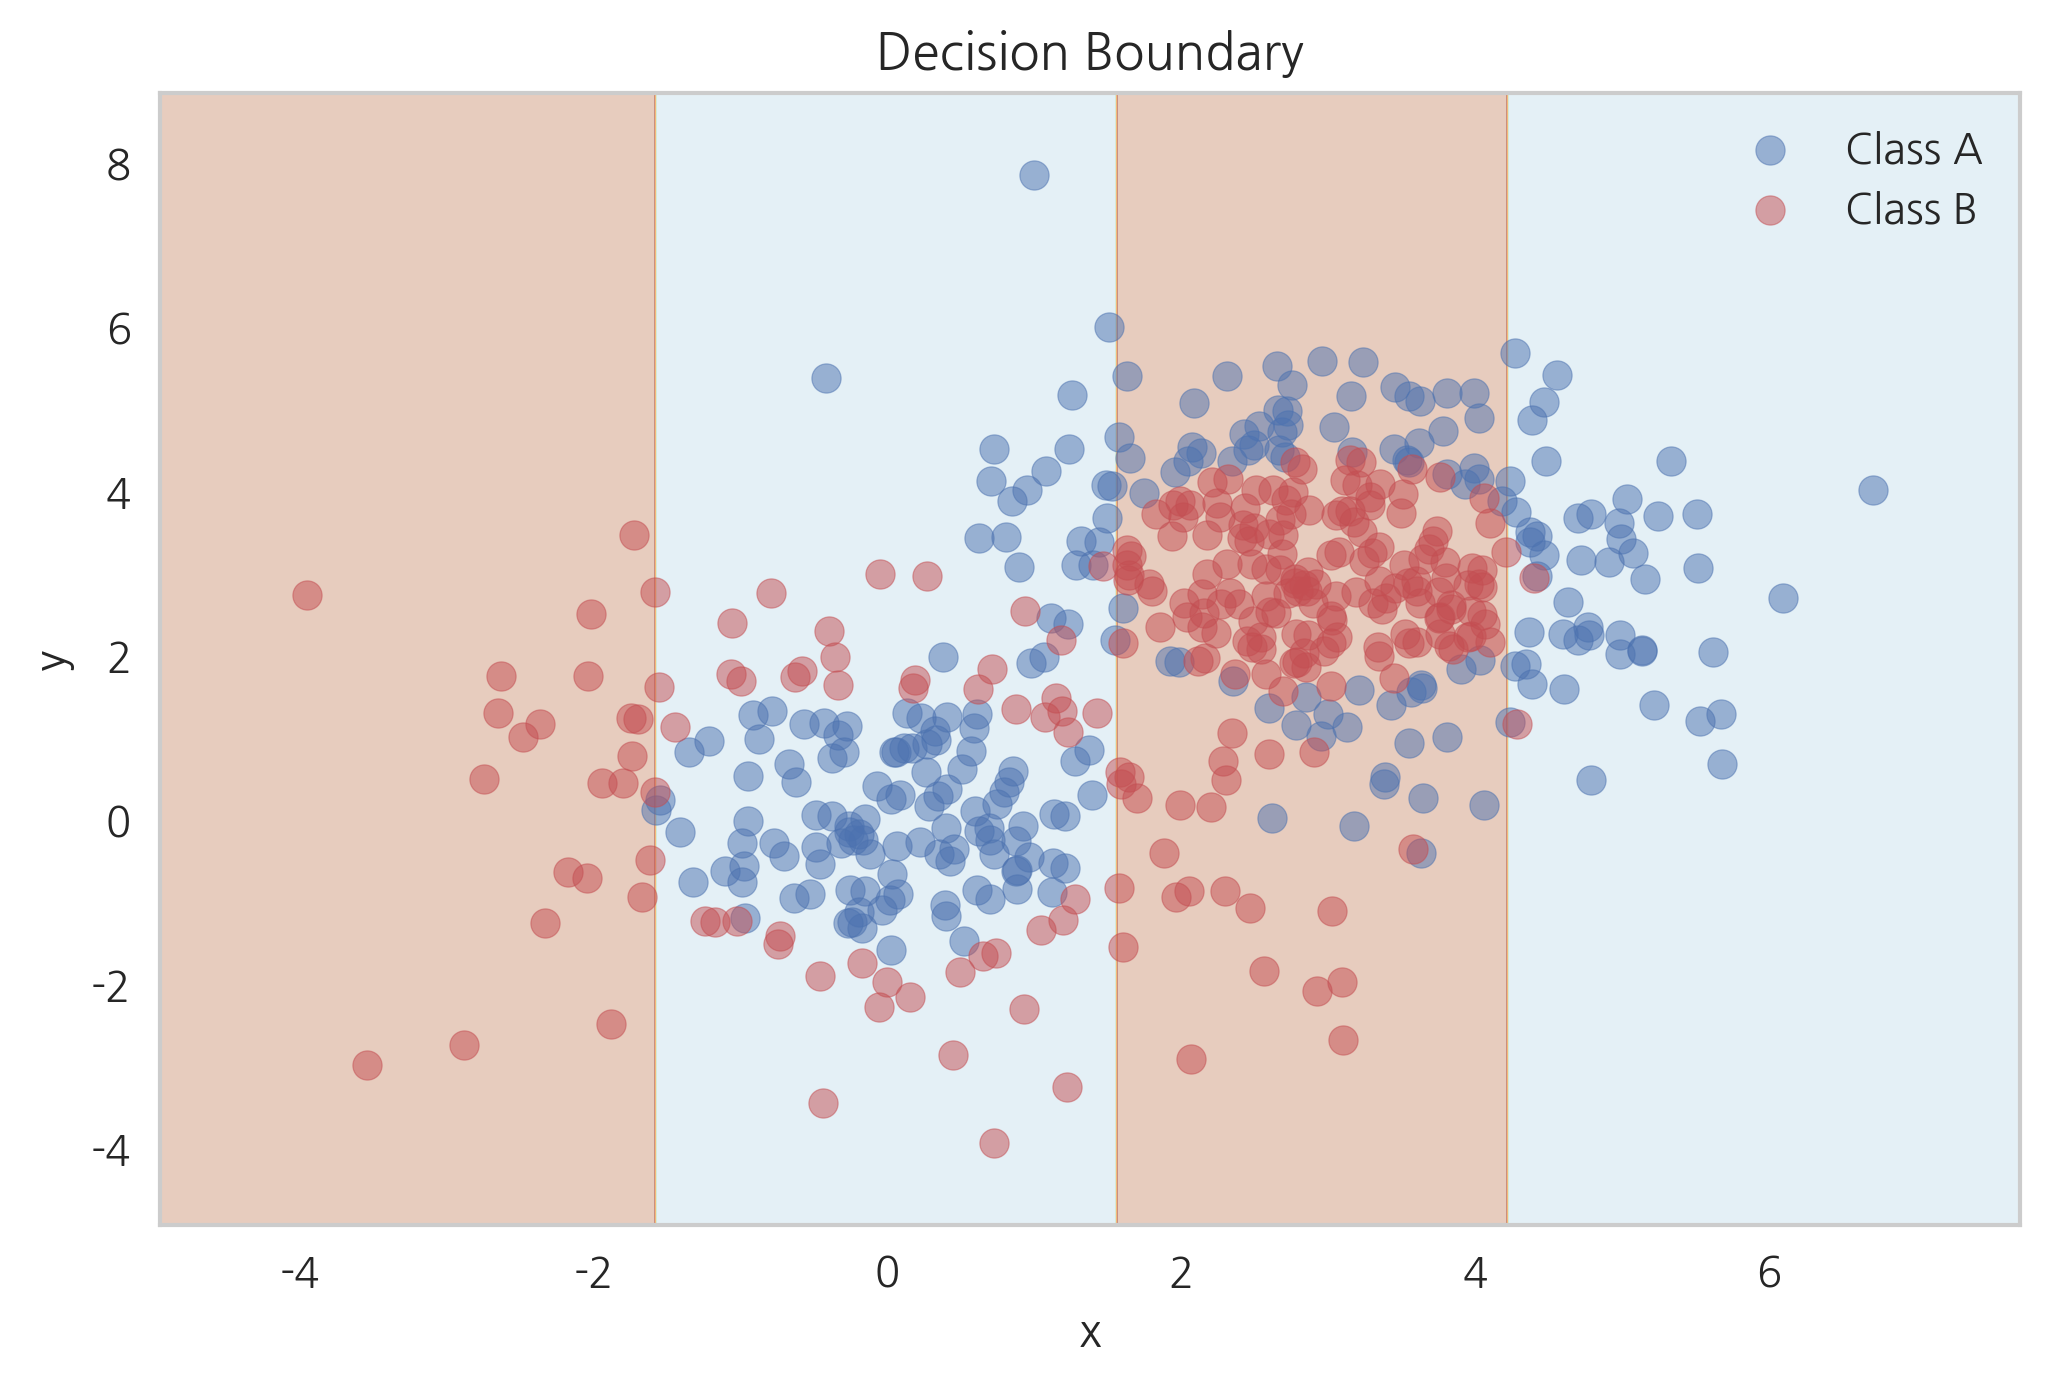

In [9]:
plot_result(model_ada.estimators_[3])

## 그레디언트 부스트

그레이던트 부스트 모형은 최적화에 사용되는 gradient descent 방법을 응용한 모형이다. 

함수 $f(x)$를 최소화하는 $x$는 다음과 같이 gradient descent 방법으로 찾을 수 있다.

$$ x_{m} = x_{m-1} - \alpha_m \dfrac{df}{dx} $$

그레디언트 부스트 모형에서는 오차 함수 또는 손실 함수(loss function) $L(y, C_{m-1})$ 을 최소화하는 weak classifier $k_m$ 은 $-\tfrac{dL(y, C_{m-1})}{dC_{m-1}}$ 임을 알 수 있다. 

$$ C_{m} = C_{m-1} - \alpha_m \dfrac{dL(y, C_{m-1})}{dC_{m-1}} = C_{m-1} + \alpha_m k_m $$

따라서 그레디언트 부스트 모형은 분류/회귀 문제에 상관없이 weak 멤버 함수로 회귀 분석 모형을 사용한다. 가장 많이 사용되는 weak 모형은 의사 결정 회귀 모형(decision tree regression model)이다. 

그레디언트 부스트 모형에서는 다음과 같은 과정을 반복하여 멤버와 그 가중치를 계산한다.

1. $-\tfrac{dL(y, C_m)}{dC_m}$ 를 target으로 하는 weak classifier $k_m$ 을 찾는다. 
2. $ \left( y - (C_{m-1} + \alpha_m k_m) \right)^2 $ 를 최소화하는 step size $\alpha_m$ 을 찾는다. 
3. $C_m = C_{m-1} + \alpha_m k_m$ 최종 모형을 갱신한다.

만약 손실함수가 오차 제곱 형태라면 gradient 는 실제 target $y$ 와   $C_{m-1}$과의 차이 즉, 잔차(residual)가 된다.

$$ L(y, C_{m-1}) = \dfrac{1}{2}(y - C_{m-1})^2 $$

$$ -\dfrac{dL(y, C_m)}{dC_m} = y - C_{m-1} $$

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [11]:
%%time
model_grad.fit(X, y)

CPU times: user 90 ms, sys: 10 ms, total: 100 ms
Wall time: 93.1 ms


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

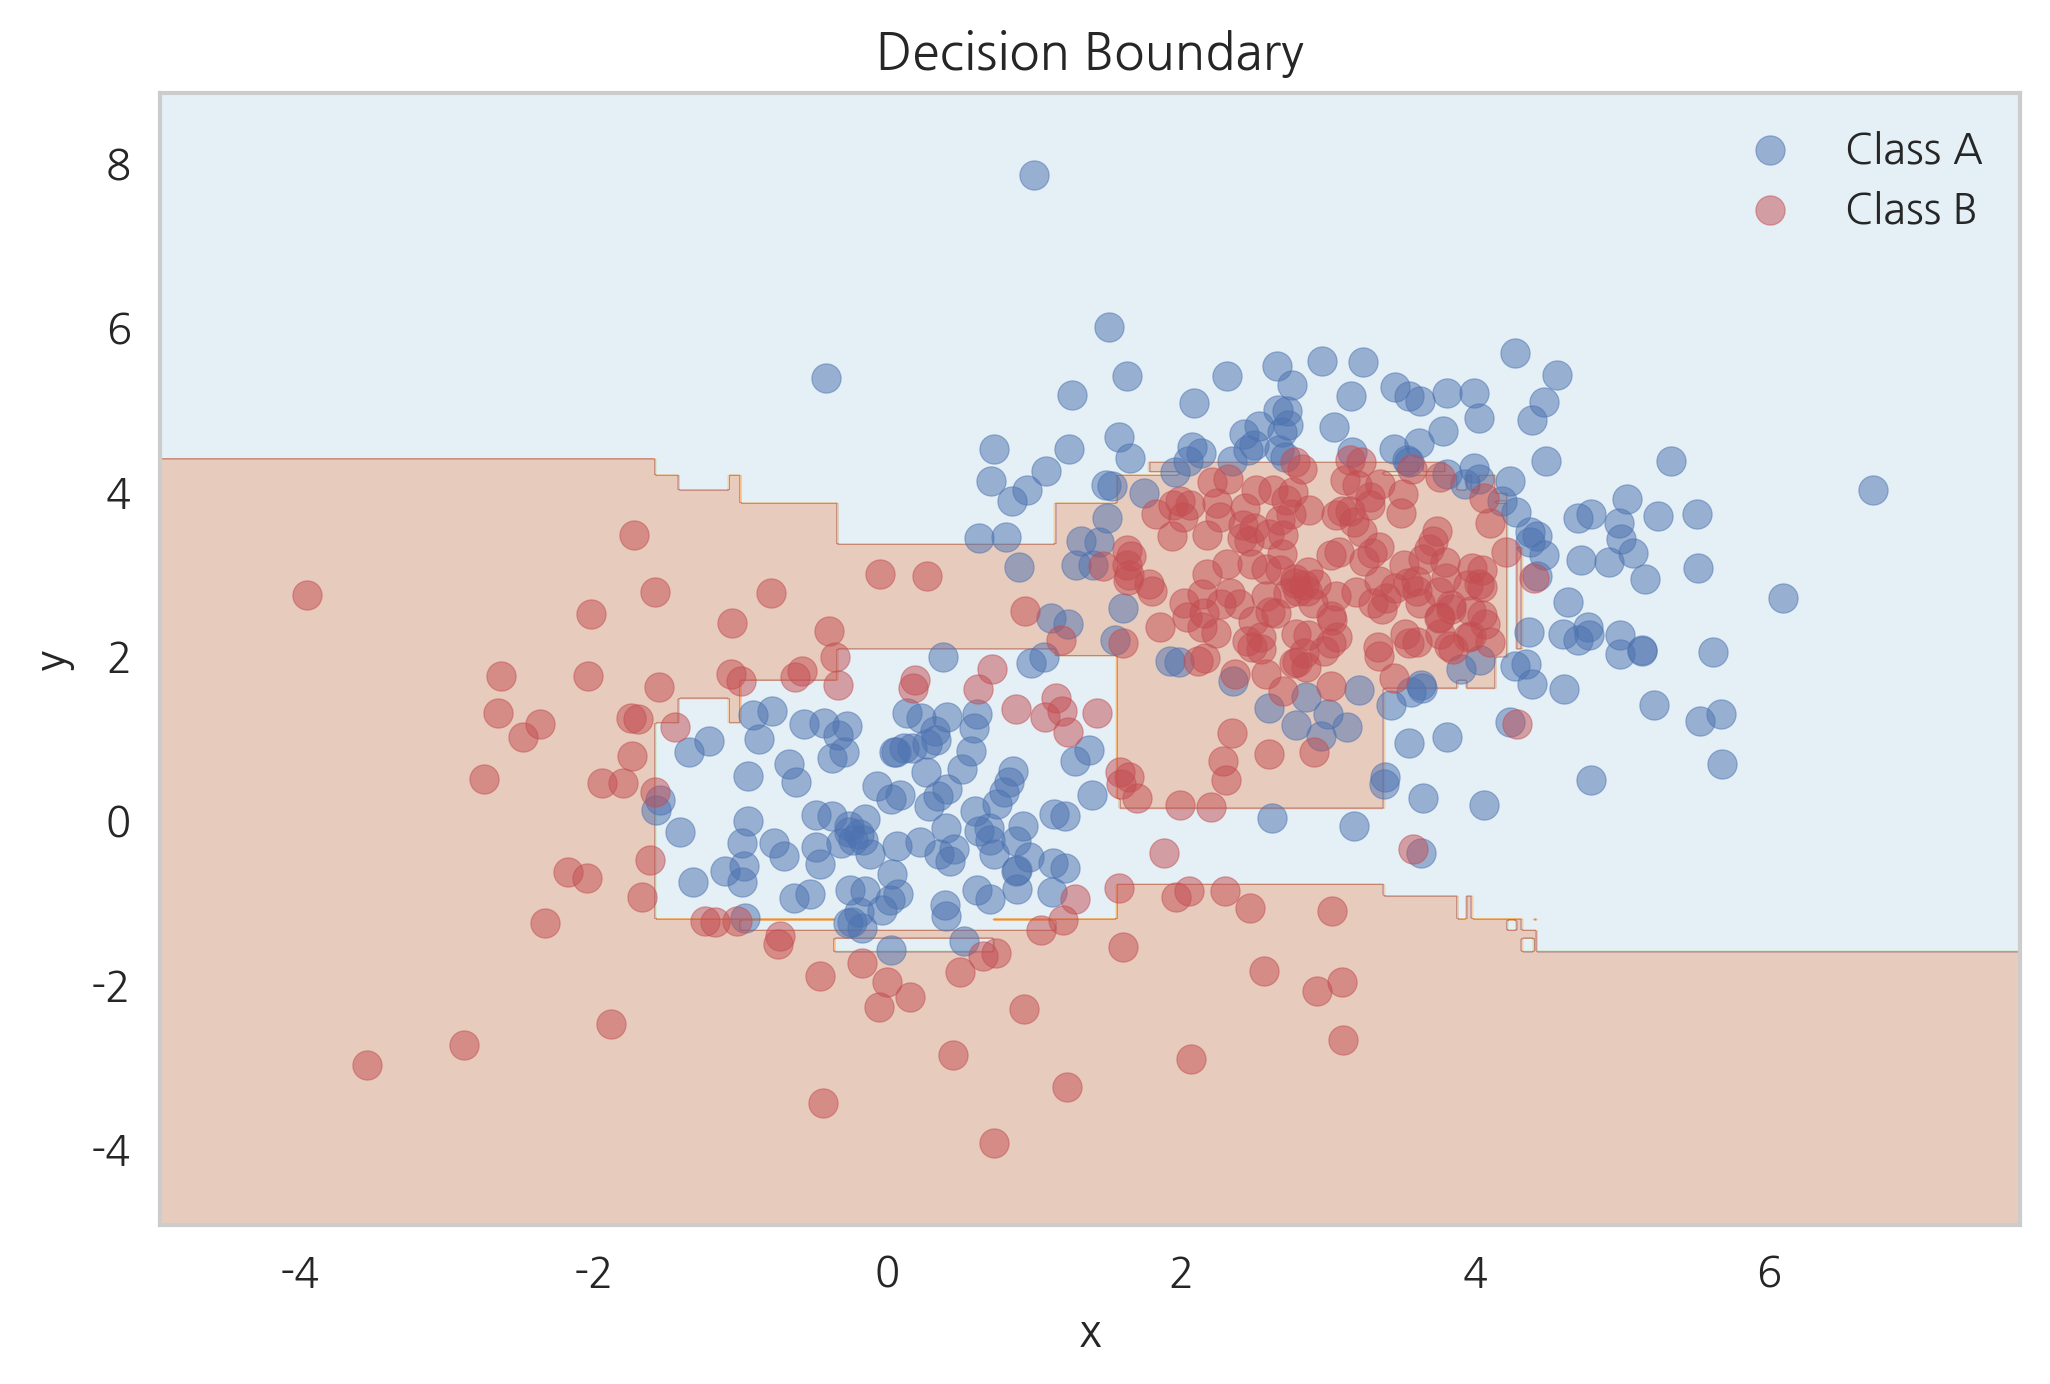

In [12]:
plot_result(model_grad)

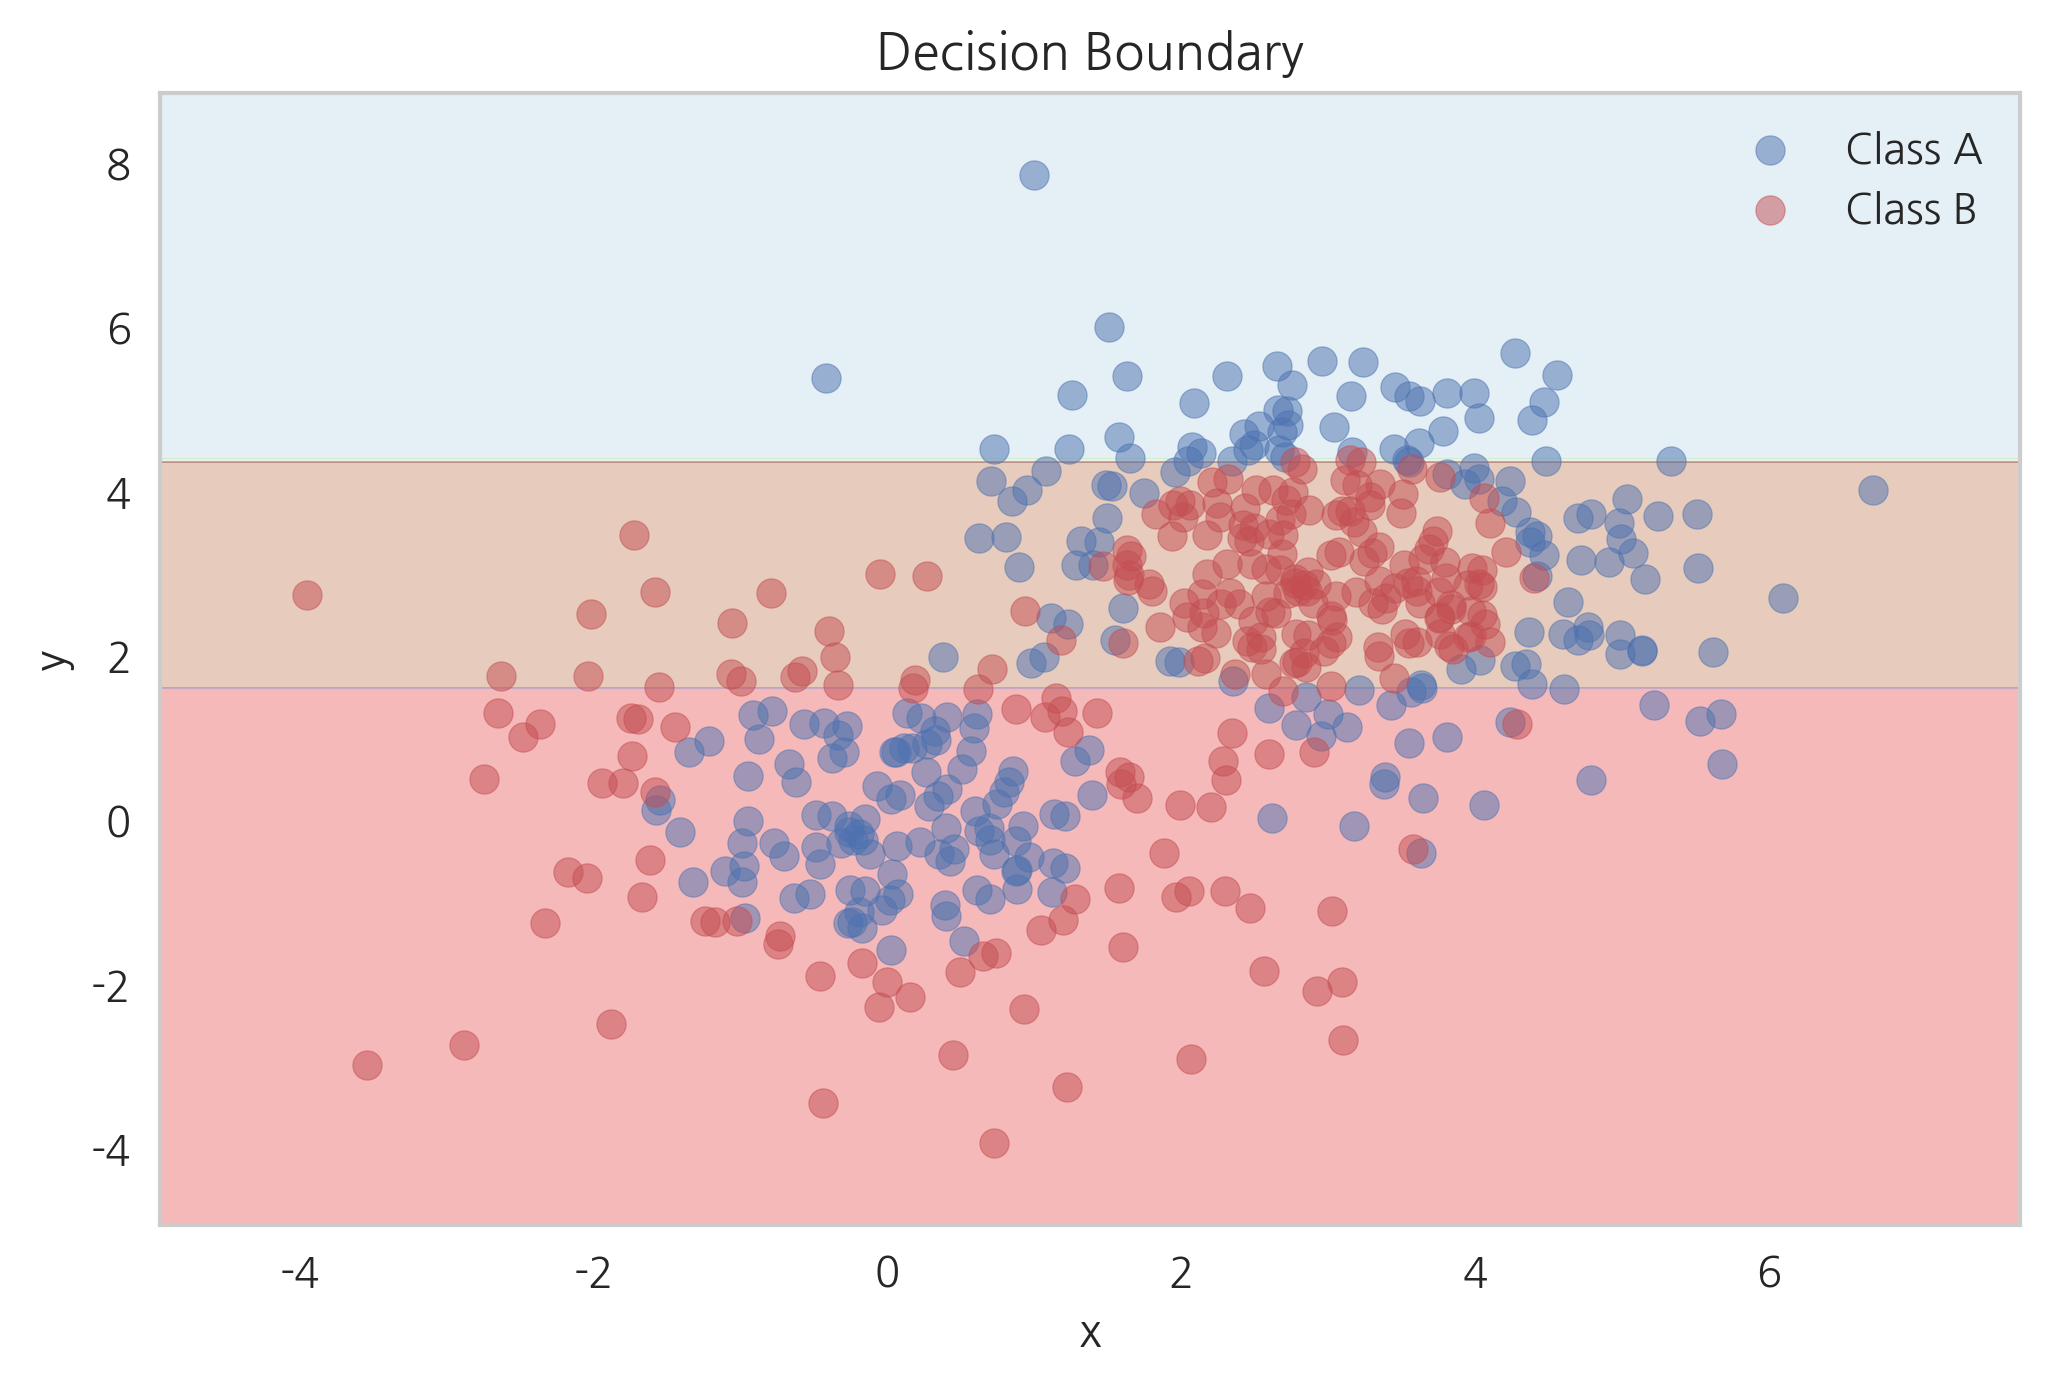

In [13]:
plot_result(model_grad.estimators_[0][0])

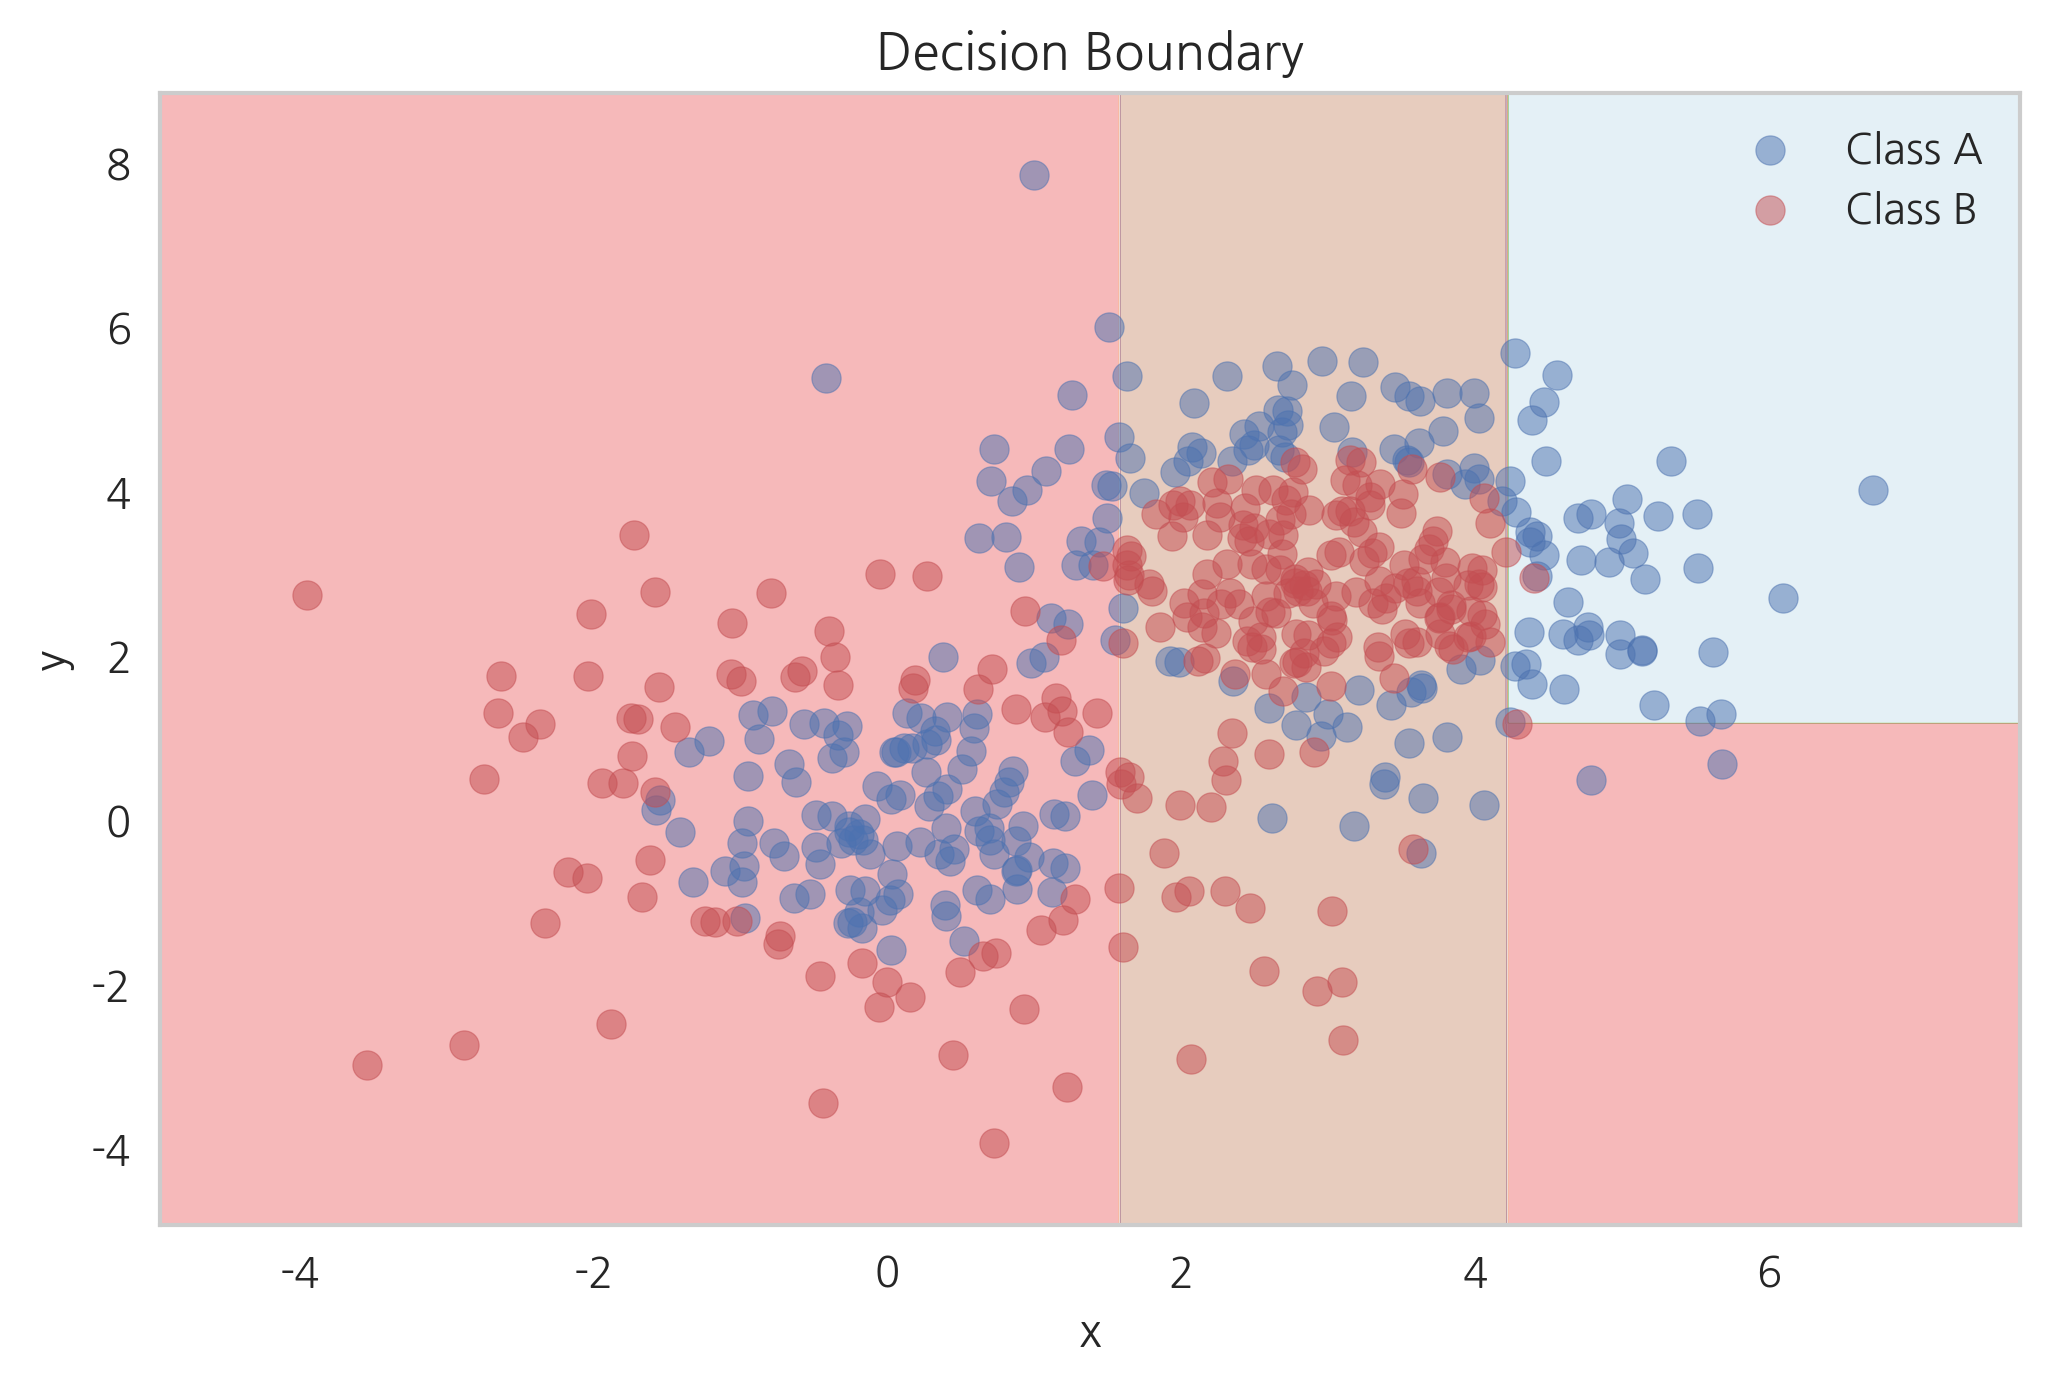

In [14]:
plot_result(model_grad.estimators_[1][0])

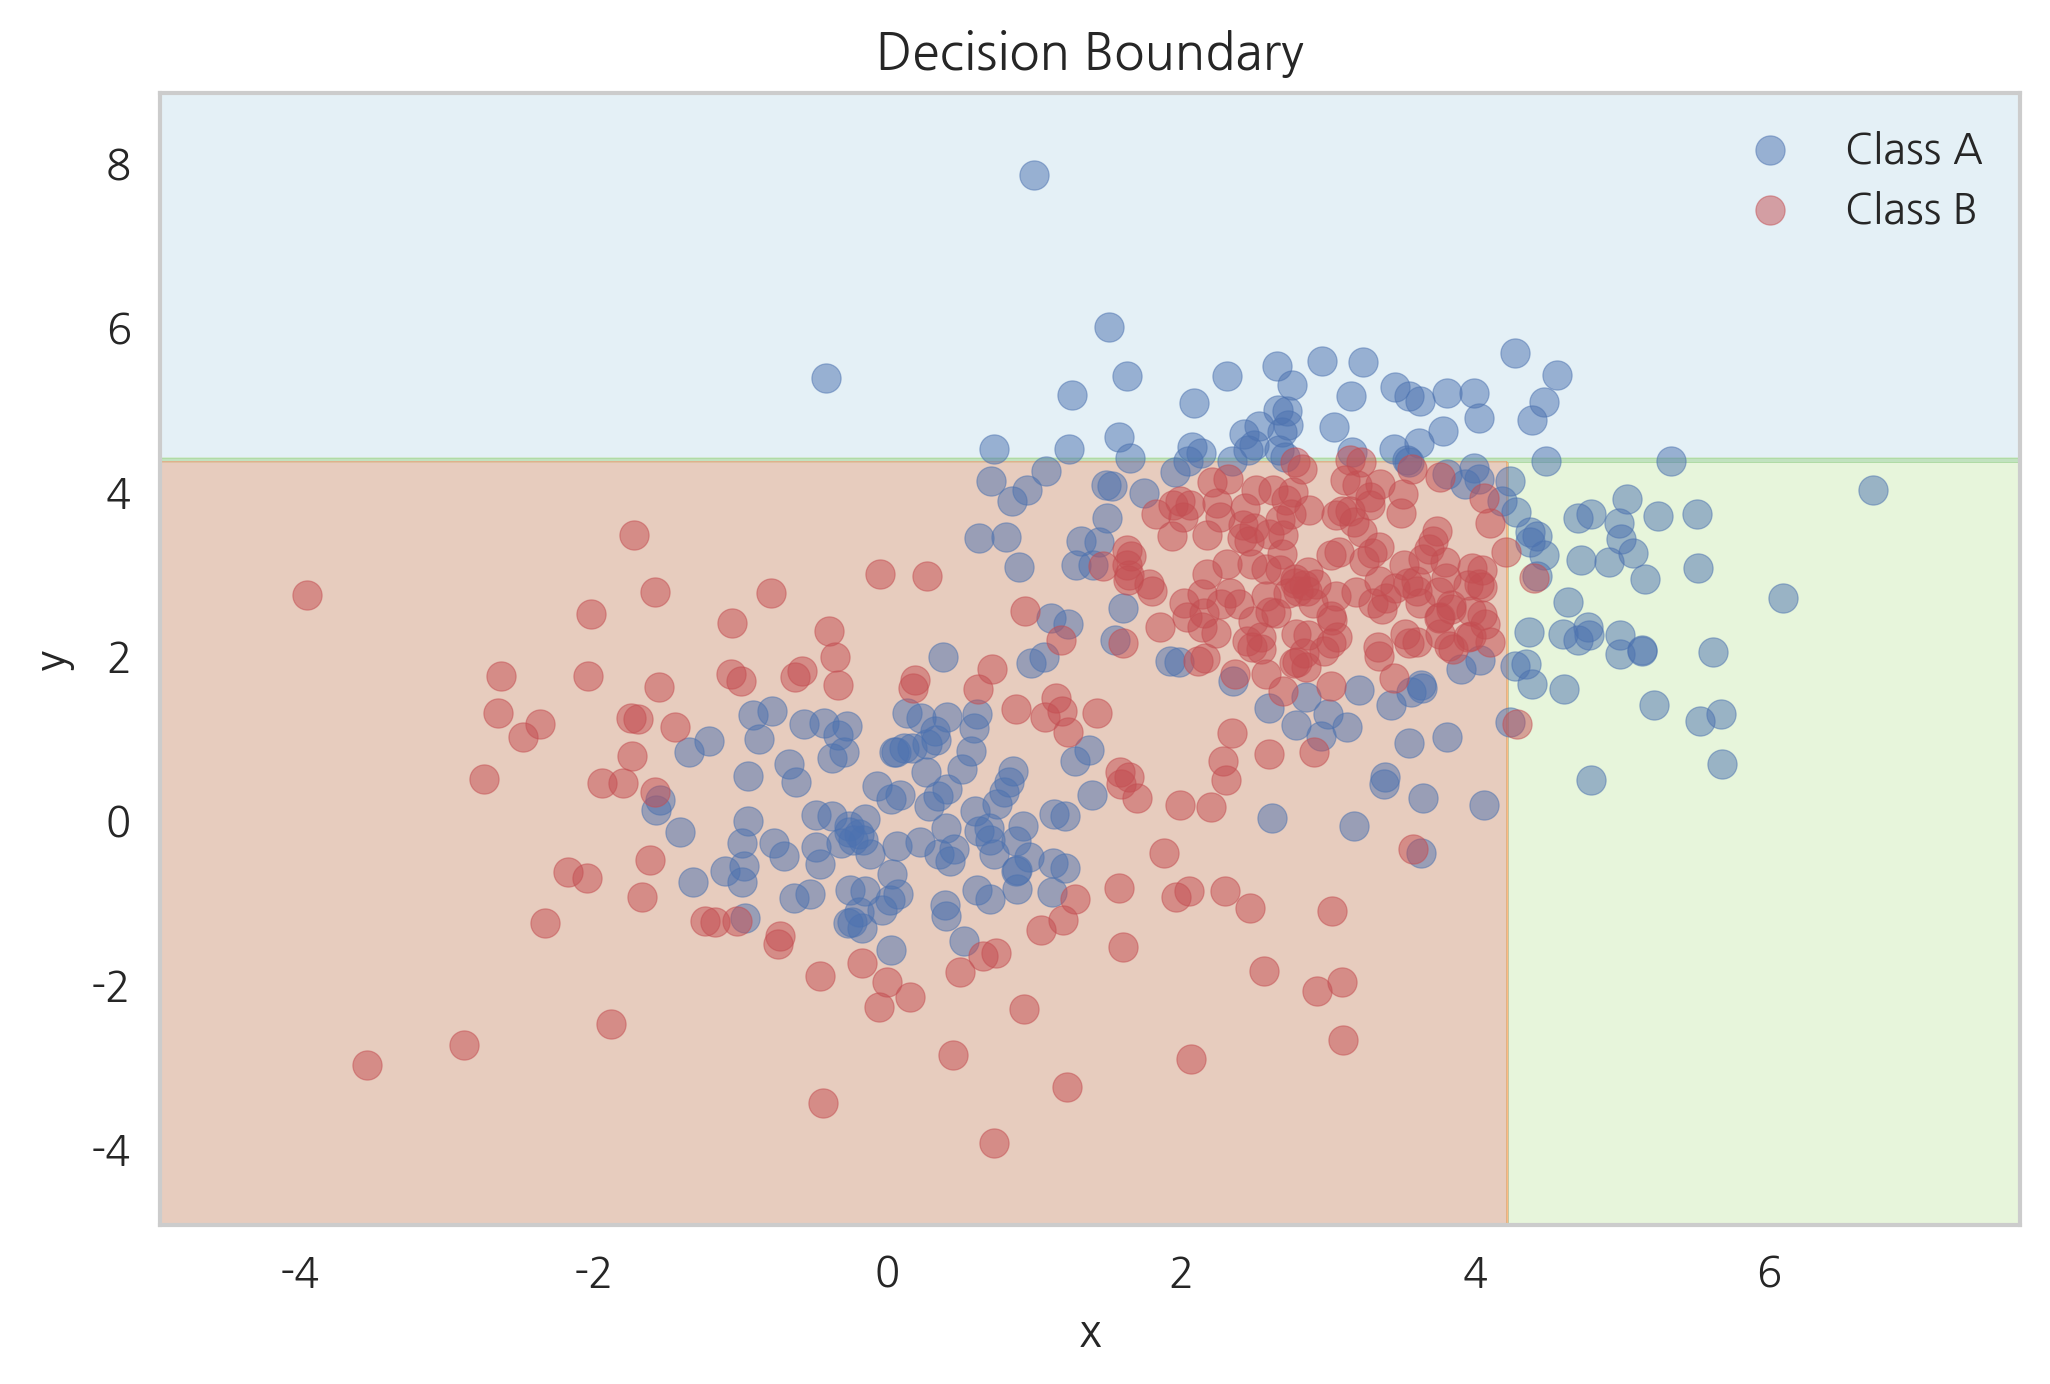

In [15]:
plot_result(model_grad.estimators_[2][0])

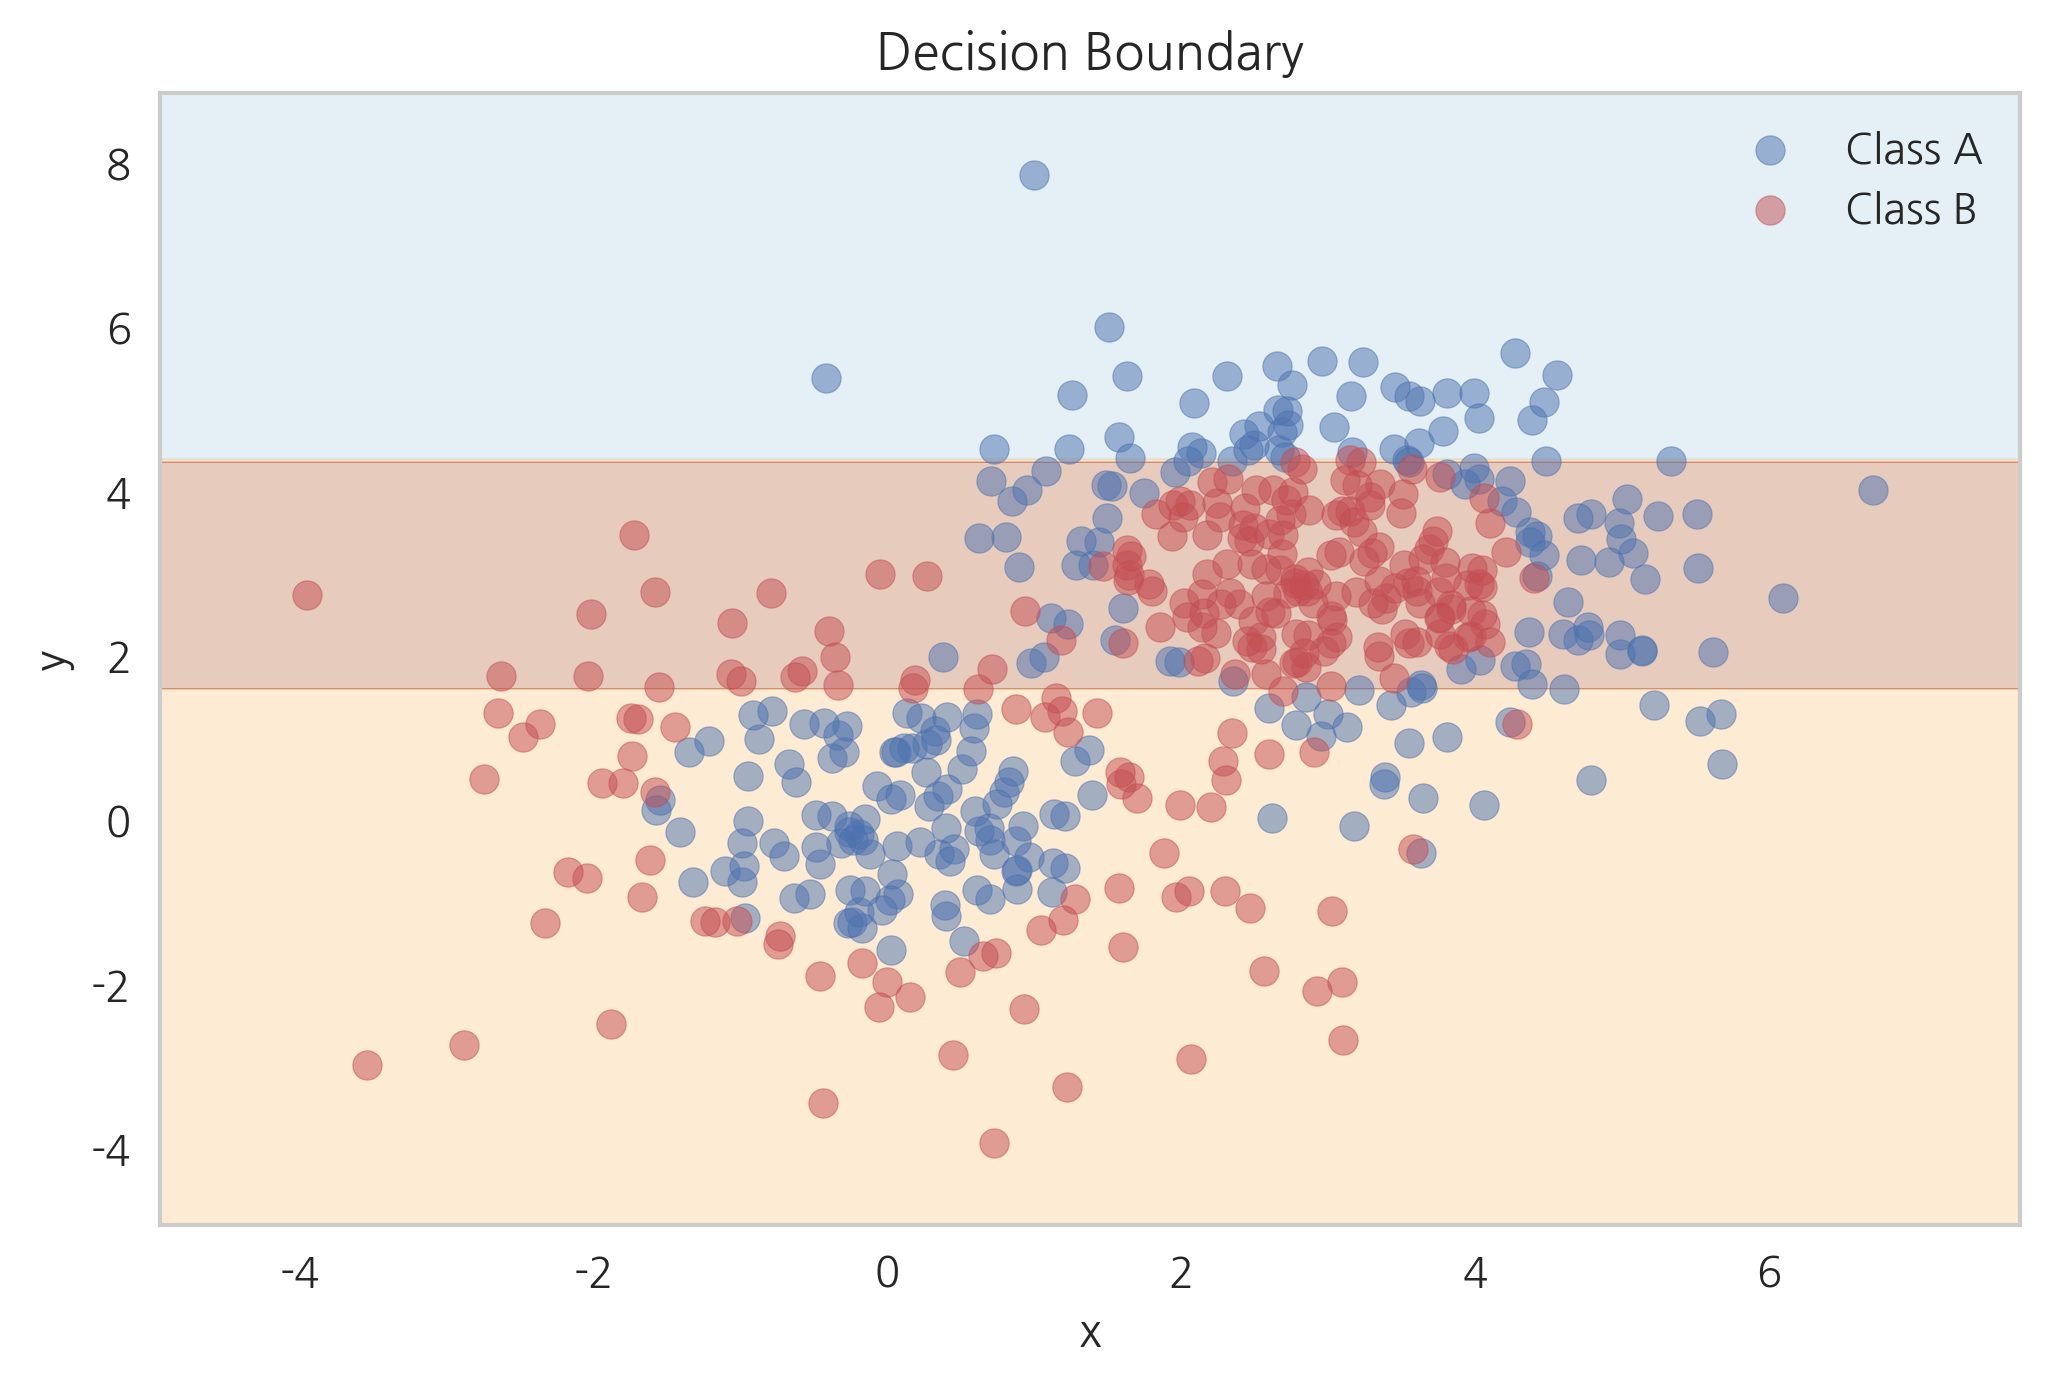

In [16]:
plot_result(model_grad.estimators_[3][0])

### XGBoost 라이브러리

In [17]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

In [18]:
%time
model_xgb.fit(X, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.6 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

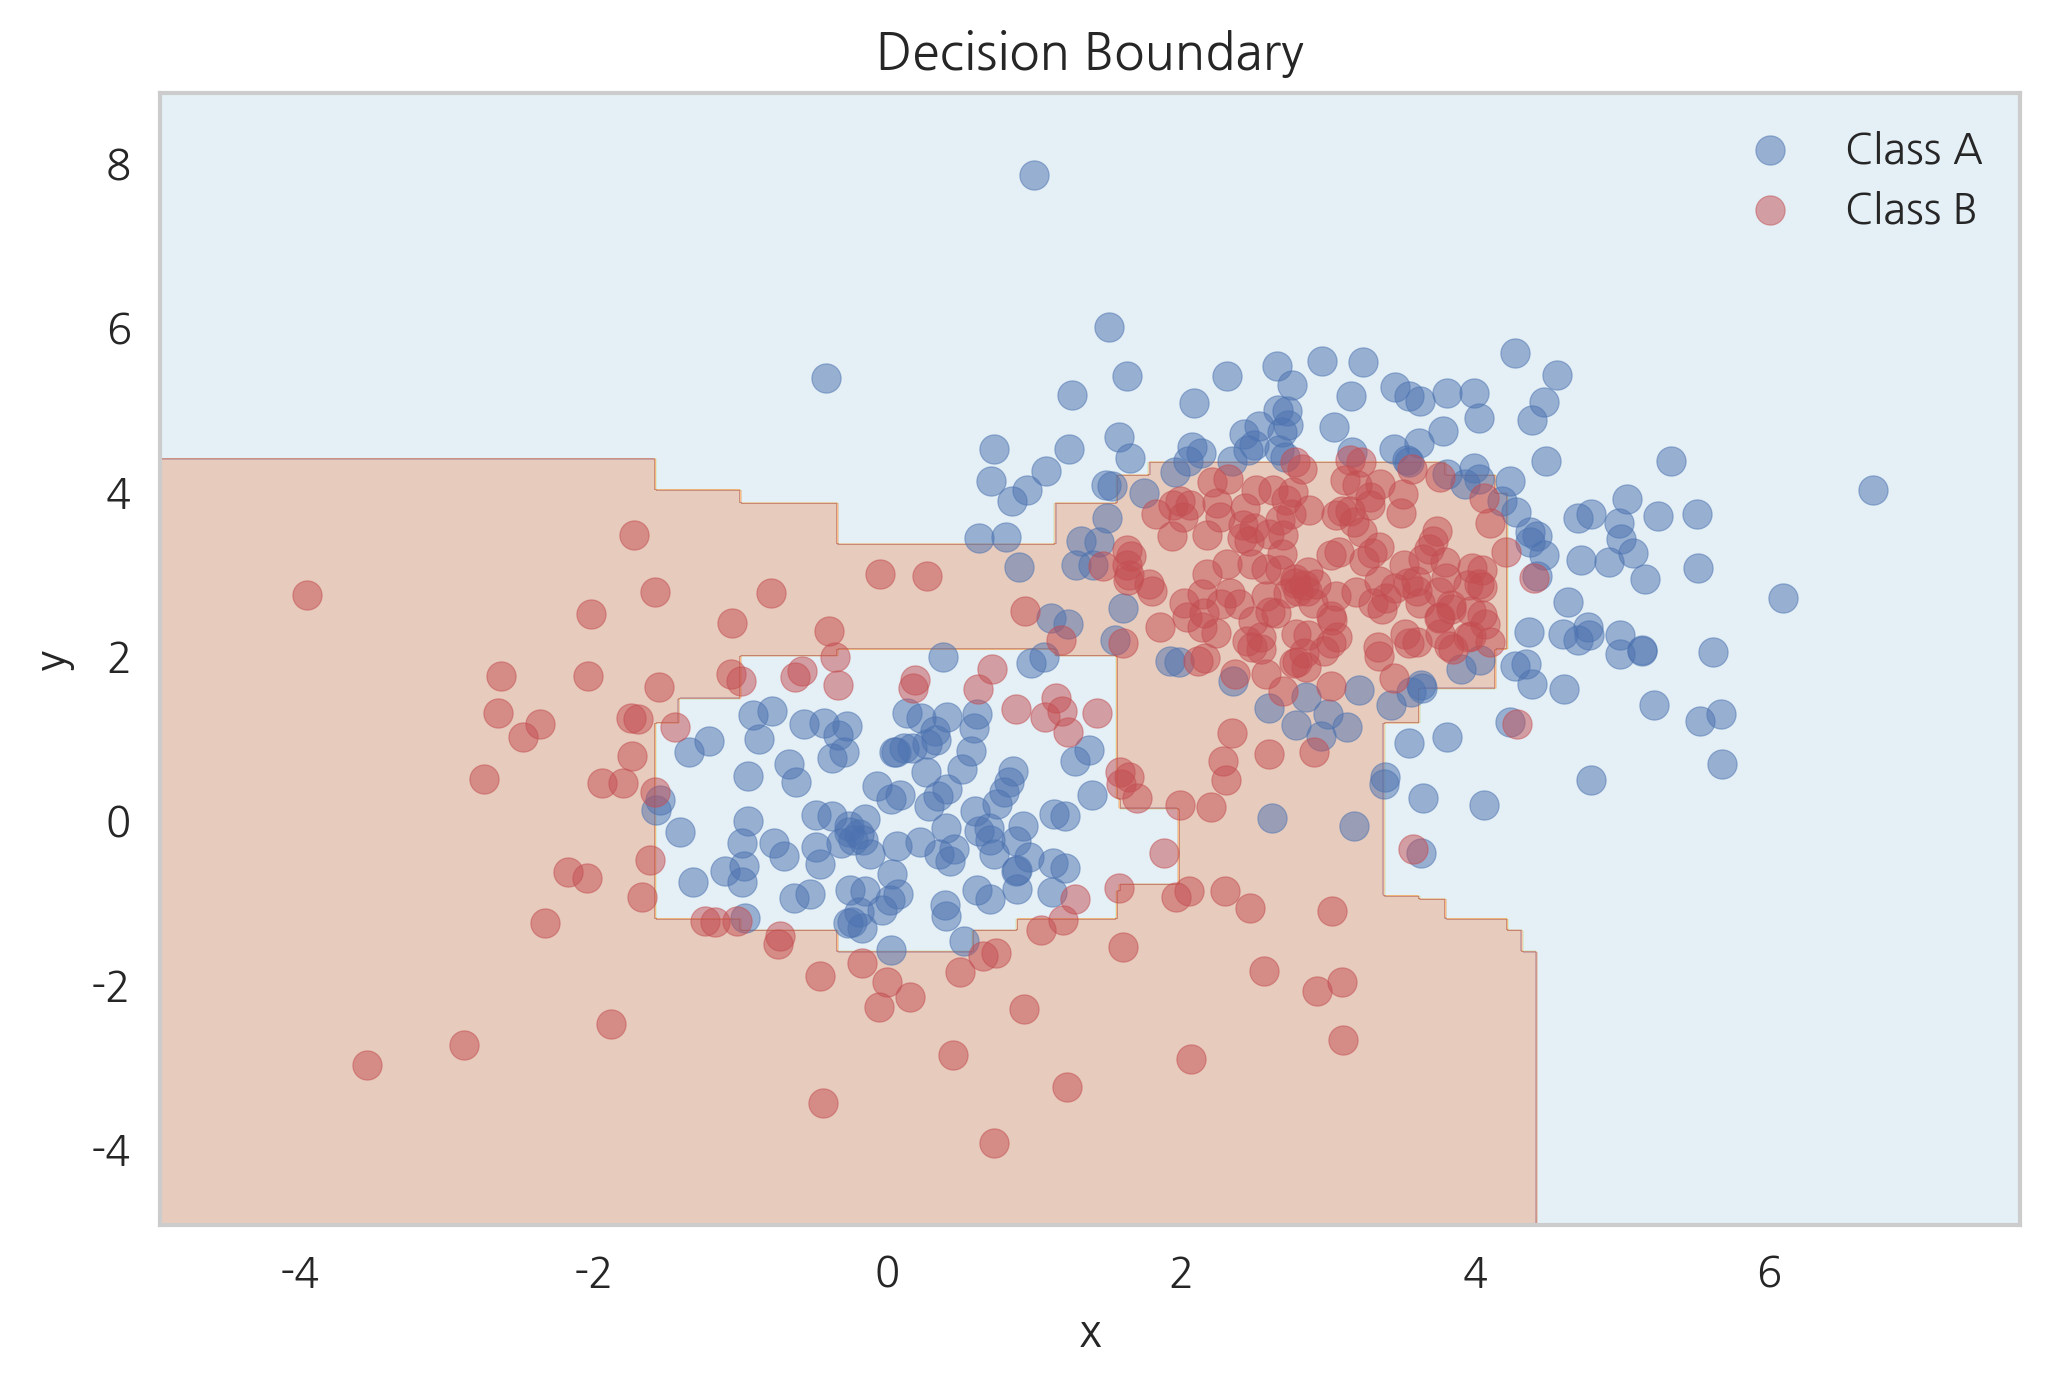

In [19]:
plot_result(model_xgb)